# IS4226 Mid Term

1. Develop backtesters for these strategies and test the strategy on in-sample data
    1. To keep things simple, all groups will test their strategy on an equal weighted portfolio of MAANG stocks from 01/01/2015 to 31/12/2019 on daily frequency data.
    2. Please note that this time, you need to do just in-sample testing and report what different variations you have tried.  In the final semester project, You will do out-of-sample testing to finalize strategies.
1. Prepare a notebook with significant markups, and please explain your code through comments. 
2. Please also describe the idea/strategy in the notebook at the start. The more understandable your notebook, the better it will be.
3. Report Strategy Risk, Returns, and performance metrics for MAANG stocks portfolio. Visualizations are optional but will be a bonus if you do that.

# Strategy 2 : Multi-Factor Reversion Strategy

# Introduction
The Multi-Factor Mean Reversion Strategy is a systematic approach designed to identify trading opportunities by leveraging a combination of price-based indicators, volume analysis, and trend-following components. The strategy aims to exploit short-term reversals in the stock price by detecting overbought and oversold conditions, while simultaneously confirming signals using volume spikes and trend direction.

This strategy integrates multiple technical analysis factors, including Z-score deviations, Bollinger Bands, and Volume Z-scores, alongside traditional short-term and long-term moving averages. By combining these factors, it filters out false signals and identifies high-probability entries and exits.

## Key Components of the Strategy
### Z-Score Analysis:

Calculates the Z-score of the closing price relative to a moving average with a configurable window parameter.
A Z-score greater than a predefined threshold (e.g., 2) indicates overbought conditions, while a Z-score below the negative threshold (e.g., -2) indicates oversold conditions.
Bollinger Bands:

### Bollinger Bands
Uses Bollinger Bands to identify price levels where a stock is trading at extreme values relative to its recent range.
Generates a buy signal when the price crosses below the lower Bollinger Band and a sell signal when the price crosses above the upper Bollinger Band.
Volume Z-Score:

### Volume Z-Score
Measures abnormal volume activity using a Volume Z-score based on a configurable window parameter rolling average.
A high positive Volume Z-score (e.g., > 2) confirms that there is unusually high interest in the current price movement, which strengthens the buy or sell signal generated by other indicators.
Trend Following Component:

### Trend Following Components
Implements moving average crossovers to determine the current trend.
Uses a short-term moving average and a long-term moving average to identify uptrends (short-term MA > long-term MA) and downtrends (short-term MA < long-term MA).


## Strategy
- Buy Signal (1):
    - When the Z-score is below the negative threshold (oversold), the price is trading below the lower Bollinger Band, the Volume Z-score is above the threshold, and the trend is up.
- Sell Signal (-1):
    - When the Z-score is above the positive threshold (overbought), the price is trading above the upper Bollinger Band and the trend is down.
- Hold Signal (0):
    - When none of the above conditions are met, indicating neutral market conditions or a lack of clear trading signals.

# Data

In [130]:
maang_stocks = [
    "MSFT",  # Microsoft
    "AAPL",  # Apple
    "AMZN",  # Amazon
    "NFLX",  # Netflix
    "GOOGL"  # Alphabet (Google)
]

# YFinanceStrategy - Analysis of a single strategy

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
import yfinance as yf
from datetime import datetime, timezone, timedelta
from matplotlib.gridspec import GridSpec

def prepare_data(symbol: str, start_date: str, end_date: str, interval: str) -> pd.DataFrame:
    """
    Prepare stock data including market cap for a given symbol. Override if more data is needed.
    
    :param symbol: Stock symbol (e.g., 'AAPL')
    :param start_date: Start date for historical data (e.g., '2020-01-01'). (YYYY-MM-DD)
    :param end_date: End date for historical data(e.g., '2020-01-01'). (YYYY-MM-DD)
    :param interval: Data interval (default is '1d' for daily)
    :return: DataFrame with prepared stock data
    """
    # Fetch stock data
    data = yf.Ticker(symbol)
    # Get historical data
    df = data.history(start=start_date, end=end_date, interval=interval).reset_index()
    # Convert date to UTC timestamp
    df['timestamp_utc'] = (pd.to_datetime(df['Date']).dt.tz_convert('UTC').astype(int) // 10**6)
    # Calculate returns and log returns
    df['returns_close'] = (df['Close'] / df['Close'].shift(1)) - 1
    df['logreturns_close'] = np.log(df['Close'] / df['Close'].shift(1))
    info = data.info
    market_cap = info.get('marketCap', None)
    df['MC'] = market_cap
    # Sort and reset index
    df = df.sort_values(by='timestamp_utc', ascending=True).reset_index(drop=True)
    return df

def calculate_beta(returns_strategy, returns_benchmark):
    covariance = np.cov(returns_strategy.dropna(), returns_benchmark.dropna())[0, 1]
    benchmark_variance = np.var(returns_benchmark.dropna())
    return covariance / benchmark_variance if benchmark_variance != 0 else np.nan

def calculate_alpha(beta, df_strategy, strategy_column, df_benchmark, benchmark_column, risk_free_rate):
    annualized_returns_strategy = calculate_annualized_return(df_strategy, strategy_column)
    annualized_returns_benchmark = calculate_annualized_return(df_benchmark, benchmark_column)
    return annualized_returns_strategy - (risk_free_rate + beta * (annualized_returns_benchmark - risk_free_rate))

def calculate_annualized_return(dataframe, column_name):
    total_return = (1 + dataframe[column_name]).prod() - 1
    n_years = len(dataframe) / 252  # Assuming 252 trading days in a year
    return (1 + total_return) ** (1 / n_years) - 1


class YFinanceStrategy:
    def __init__(self, symbol: str, start_date: str, end_date: str, interval: str, params : dict = {}, benchmark_symbol : str = "^GSPC", risk_free_rate : float = 0.0) -> None:
        self.symbol = symbol
        self.benchmark_symbol = benchmark_symbol
        self.start_date = start_date
        self.end_date = end_date
        self.interval = interval
        self.params = params
        self.trades = None
        self.performance = None
        self.data_strategy = prepare_data(symbol=self.symbol, start_date=self.start_date, end_date=self.end_date, interval=self.interval)
        self.data_benchmark = prepare_data(symbol=self.benchmark_symbol, start_date=self.start_date, end_date=self.end_date, interval=self.interval)
        self.risk_free_rate = risk_free_rate
    def strategy(self) -> pd.DataFrame:
        """
        Generate a signal column, 1 for Long, -1 for Short, 0 for no position.
        """
        raise NotImplementedError("Strategy method must be implemented")

    def generate_trades(self, strategy_signal_column='signal', strategy_price_column='Close') -> pd.DataFrame:
        """
        Calculate trades based on the strategy signal.
        """
        if self.data_strategy is None:
            raise ValueError("Data must be fetched first. Try calling self.fetch_data()")
        if self.data_strategy[strategy_signal_column].mean() == 0:
            print("No trades executed")
            self.trades = []
        
        self.data_strategy['signal_change'] = self.data_strategy[strategy_signal_column] != self.data_strategy[strategy_signal_column].shift(1)
        
        trades = []
        open_trade = None

        for idx, row in self.data_strategy[self.data_strategy['signal_change']].iterrows():
            current_signal = row[strategy_signal_column]
            
            if open_trade is None:
                if current_signal != 0:
                    open_trade = {
                        'entry_datetime': datetime.fromtimestamp(row['timestamp_utc'] / 1000, tz=timezone.utc),
                        'entry_price': row[strategy_price_column],
                        'position': current_signal
                    }
            else:
                exit_datetime = datetime.fromtimestamp(row['timestamp_utc'] / 1000, tz=timezone.utc)
                duration = exit_datetime - open_trade['entry_datetime']
                exit_price = row[strategy_price_column]
                pnl = (exit_price - open_trade['entry_price']) * open_trade['position']
                pnl_pct = (pnl / abs(open_trade['entry_price'])) * 100
                
                trades.append({
                    'entry_datetime': open_trade['entry_datetime'],
                    'exit_datetime': exit_datetime,
                    'duration': duration,
                    'entry_price': open_trade['entry_price'],
                    'exit_price': exit_price,
                    'pnl': pnl,
                    'pnl%': pnl_pct,
                    'position': open_trade['position'],
                    'win': 1 if pnl > 0 else 0
                })
                
                if current_signal != 0:
                    open_trade = {
                        'entry_datetime': exit_datetime,
                        'entry_price': exit_price,
                        'position': current_signal
                    }
                else:
                    open_trade = None
        
        if open_trade is not None:
            last_row = self.data_strategy.iloc[-1]
            exit_datetime = datetime.fromtimestamp(last_row['timestamp_utc'] / 1000, tz=timezone.utc)
            duration = exit_datetime - open_trade['entry_datetime']
            exit_price = last_row[strategy_price_column]
            pnl = (exit_price - open_trade['entry_price']) * open_trade['position']
            pnl_pct = (pnl / abs(open_trade['entry_price'])) * 100
            
            trades.append({
                'entry_datetime': open_trade['entry_datetime'],
                'exit_datetime': exit_datetime,
                'duration': duration,
                'entry_price': open_trade['entry_price'],
                'exit_price': exit_price,
                'pnl': pnl,
                'pnl%': pnl_pct,
                'position': open_trade['position'],
                'win': 1 if pnl > 0 else 0
            })
        self.trades = trades
        # return trades
    def calculate_trades_performance(self):
        """
        Calculate trades performance metrics. calculate_trades() must be called first.
        """
        if self.trades is None:
            raise ValueError("Trades must be calculated first. Try calling self.calculate_trades()")
        if self.trades == []:
            print("No trades executed. Empty Trades performance.")
            return {}
        df_trades = pd.DataFrame(self.trades)
        num_trades = len(df_trades)
        win_rate = round(df_trades['win'].mean(), 5)
        avg_win = df_trades[df_trades['win'] == 1]['pnl'].mean()
        avg_loss = abs(df_trades[df_trades['win'] == 0]['pnl'].mean())
        reward_risk_ratio = avg_win / avg_loss if avg_loss != 0 else np.inf
        expectancy = (win_rate * avg_win) - ((1 - win_rate) * avg_loss)
        avg_duration = df_trades['duration'].mean()
        
        return {
            'number_of_trades': num_trades,
            'win_rate': win_rate,
            'reward_risk_ratio': reward_risk_ratio,
            'expectancy': expectancy,
            'avg_trade_duration': avg_duration,
        }
    def calculate_strategy_metrics(self) -> Dict[str, float]:
        if self.trades is None:
            raise ValueError("Trades must be calculated first. Try calling self.calculate_trades()")
        if self.trades == []:
            print("No trades executed. Empty Trades performance.")
            self.performance = {}
            return
        beta = calculate_beta(returns_strategy=self.data_strategy['returns_strategy'], 
                            returns_benchmark=self.data_benchmark['returns_close'])
        alpha = calculate_alpha(beta = beta,
                                df_strategy = self.data_strategy, strategy_column = 'returns_strategy',
                                df_benchmark = self.data_benchmark, benchmark_column = 'returns_close',
                                risk_free_rate = 0)
        annualized_returns = calculate_annualized_return(dataframe=self.data_strategy, column_name='returns_strategy')
        annualized_volatility = self.data_strategy['returns_strategy'].std() * np.sqrt(252)
        annualized_sharpe = ((calculate_annualized_return(self.data_strategy, 'returns_strategy') - self.risk_free_rate) / self.data_strategy['returns_strategy'].std()) * np.sqrt(252)

        downside_returns = self.data_strategy['returns_strategy'][self.data_strategy['returns_strategy'] < 0]
        downside_std = downside_returns.std()
        annualized_sortino = ((calculate_annualized_return(self.data_strategy, 'returns_strategy') - self.risk_free_rate) / downside_std) * np.sqrt(252)
    
        cumulative_returns = (1 + self.data_strategy['returns_strategy']).cumprod()
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns / peak) - 1
        max_drawdown = drawdown.min()
        annualized_calmar = calculate_annualized_return(self.data_strategy, 'returns_strategy') / abs(max_drawdown) if max_drawdown != 0 else np.inf
        annualized_treynor = (calculate_annualized_return(self.data_strategy, 'returns_strategy') - self.risk_free_rate) / beta
        annualized_information = (calculate_annualized_return(self.data_strategy, 'returns_strategy') - calculate_annualized_return(self.data_benchmark, 'returns_close')) / (self.data_strategy['returns_strategy'] - self.data_benchmark['returns_close']).std()
        
        omega_ratio = np.mean(np.maximum(self.data_strategy['returns_strategy'] - self.risk_free_rate, 0)) / np.mean(np.maximum(self.risk_free_rate - self.data_strategy['returns_strategy'], 0)) if np.mean(np.maximum(self.risk_free_rate - self.data_strategy['returns_strategy'], 0)) != 0 else (np.inf if np.mean(np.maximum(self.data_strategy['returns_strategy'] - self.risk_free_rate, 0)) > 0 else 0)
        
        profit_factor = self.data_strategy['returns_strategy'][self.data_strategy['returns_strategy'] > 0].sum() / -self.data_strategy['returns_strategy'][self.data_strategy['returns_strategy'] < 0].sum() if -self.data_strategy['returns_strategy'][self.data_strategy['returns_strategy'] < 0].sum() != 0 else np.inf
        recovery_factor = ((1 + self.data_strategy['returns_strategy']).prod() - 1) / abs(max_drawdown) if max_drawdown != 0 else np.inf
        return {
            'beta': beta,
            'alpha': alpha,
            'annualized_returns': annualized_returns,
            'annualized_volatility': annualized_volatility,
            'annualized_sharpe': annualized_sharpe,
            'annualized_sortino': annualized_sortino,
            'max_drawdown': max_drawdown,
            'annualized_calmar': annualized_calmar,
            'annualized_treynor': annualized_treynor,
            'annualized_information': annualized_information,
            'omega_ratio': omega_ratio,
            'profit_factor': profit_factor,
            'recovery_factor': recovery_factor
        }
    def calculate_strategy_performance(self) -> None:
        """
        Calculate strategy performance metrics. calculate_trades() must be called first.

        Metrics:
        - Cumulative Returns
        - Annualized Returns

        """
        self.data_strategy['returns_strategy'] = self.data_strategy['signal'].shift(1) * self.data_strategy['returns_close']
        self.data_strategy['logreturns_strategy'] = self.data_strategy['signal'].shift(1) * np.log(1 + self.data_strategy['returns_close'])
        
        self.generate_trades()
        trades_performance = self.calculate_trades_performance()
        strategy_performance = self.calculate_strategy_metrics()
        if trades_performance != {} and strategy_performance != {}:
            self.performance = {**trades_performance, **strategy_performance}
        # confidence = self.calculate_confidence_metrics

    def plot_performance(self) -> None:
        """
        Plot strategy performance metrics in a single, comprehensive image.
        """
        if self.performance is None:
            raise ValueError("Performance metrics must be calculated first. Try calling self.calculate_strategy_performance()")
        
        # Set up the plot
        fig = plt.figure(figsize=(20, 20))
        
        # Set the main title for the entire figure
        fig.suptitle(f"""{self.symbol} Strategy Performance""", fontsize=16, y=0.95)

        gs = GridSpec(4, 3)
        
        # 1. Close Prices Plot (New)
        ax_close = plt.subplot(gs[0, :])
        ax_close.plot(self.data_strategy['Date'], self.data_strategy['Close'], label='Strategy', color='blue')
        ax_close.set_ylabel('Strategy Close Price', color='blue')
        ax_close.tick_params(axis='y', labelcolor='blue')
        
        ax_close_benchmark = ax_close.twinx()
        ax_close_benchmark.plot(self.data_benchmark['Date'], self.data_benchmark['Close'], label='Benchmark', color='orange')
        ax_close_benchmark.set_ylabel('Benchmark Close Price', color='orange')
        ax_close_benchmark.tick_params(axis='y', labelcolor='orange')
        
        ax_close.set_title('Close Prices: Strategy vs Benchmark')
        lines1, labels1 = ax_close.get_legend_handles_labels()
        lines2, labels2 = ax_close_benchmark.get_legend_handles_labels()
        ax_close.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

        # 2. Cumulative Returns Plot with Signal Indicators
        ax1 = plt.subplot(gs[1, :])
        cumulative_returns = (1 + self.data_strategy['returns_strategy']).cumprod()
        cumulative_benchmark = (1 + self.data_benchmark['returns_close']).cumprod()

        # Plot benchmark first (in the background)
        ax1.plot(self.data_benchmark['Date'], cumulative_benchmark, label='Benchmark', color='gray', zorder=1)

        # Color-coded area for strategy based on signal
        for i in range(len(self.data_strategy) - 1):
            start_date = self.data_strategy['Date'].iloc[i]
            end_date = self.data_strategy['Date'].iloc[i + 1]
            start_value = cumulative_returns.iloc[i]
            end_value = cumulative_returns.iloc[i + 1]
            
            if self.data_strategy['signal'].iloc[i] == 1:  # Long position
                ax1.fill_between([start_date, end_date], [start_value, end_value], color='green', alpha=0.1, zorder=2)
            elif self.data_strategy['signal'].iloc[i] == -1:  # Short position
                ax1.fill_between([start_date, end_date], [start_value, end_value], color='red', alpha=0.1, zorder=2)

        # Plot strategy line on top
        ax1.plot(self.data_strategy['Date'], cumulative_returns, label='Strategy', color='black', zorder=3)

        ax1.set_title('Cumulative Returns with Position Indicators')
        ax1.set_ylabel('Cumulative Returns')

        # Add custom legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='green', edgecolor='none', alpha=0.3, label='Long'),
            Patch(facecolor='red', edgecolor='none', alpha=0.3, label='Short'),
            Patch(facecolor='gray', edgecolor='none', alpha=0.1, label='No Position')
        ]
        ax1.legend(handles=legend_elements + ax1.get_legend_handles_labels()[0], 
                labels=['Long', 'Short', 'No Position', 'Strategy', 'Benchmark'], 
                loc='upper left')

        # 3. Drawdown Plot
        ax2 = plt.subplot(gs[2, :])
        drawdown = (cumulative_returns / cumulative_returns.cummax()) - 1
        ax2.fill_between(self.data_strategy['Date'], drawdown, 0, alpha=0.3)
        ax2.set_title('Drawdown')
        ax2.set_ylabel('Drawdown')

        # 4. Key Metrics Table
        ax3 = plt.subplot(gs[3, 0])
        metrics = [
            ('Number of Trades', f"{self.performance['number_of_trades']}"),
            ('Win Rate', f"{self.performance['win_rate']:.2%}"),
            ('Annualized Returns', f"{self.performance['annualized_returns']:.2%}"),
            ('Annualized Volatility', f"{self.performance['annualized_volatility']:.2%}"),
            ('Sharpe Ratio', f"{self.performance['annualized_sharpe']:.2f}"),
            ('Sortino Ratio', f"{self.performance['annualized_sortino']:.2f}"),
            ('Max Drawdown', f"{self.performance['max_drawdown']:.2%}"),
            ('Calmar Ratio', f"{self.performance['annualized_calmar']:.2f}"),
            ('Beta', f"{self.performance['beta']:.2f}"),
            ('Alpha', f"{self.performance['alpha']:.2%}"),
            ('Information Ratio', f"{self.performance['annualized_information']:.2f}"),
            ('Omega Ratio', f"{self.performance['omega_ratio']:.2f}"),
            ('Profit Factor', f"{self.performance['profit_factor']:.2f}"),
            ('Recovery Factor', f"{self.performance['recovery_factor']:.2f}"),
            ('Reward Risk Ratio', f"{self.performance['reward_risk_ratio']:.2f}"),
            ('Expectancy', f"{self.performance['expectancy']:.2f}"),
            ('Avg Trade Duration', f"{self.performance['avg_trade_duration']}")
        ]
        ax3.axis('tight')
        ax3.axis('off')
        ax3.table(cellText=metrics, colLabels=['Metric', 'Value'], cellLoc='center', loc='center')

        # 5. Risk-Return Scatter Plot
        ax4 = plt.subplot(gs[3, 1])
        ax4.scatter(self.performance['annualized_volatility'], self.performance['annualized_returns'], 
                    s=200, color='red', label='Strategy')
        ax4.scatter(self.data_benchmark['returns_close'].std() * np.sqrt(252), 
                    calculate_annualized_return(self.data_benchmark, 'returns_close'),
                    s=200, color='blue', label='Benchmark')
        ax4.set_xlabel('Annualized Volatility')
        ax4.set_ylabel('Annualized Returns')
        ax4.set_title('Risk-Return Profile')
        ax4.legend()

        # 6. Distribution of Returns
        ax5 = plt.subplot(gs[3, 2])
        sns.histplot(self.data_strategy['returns_strategy'], kde=True, ax=ax5)
        ax5.set_title('Distribution of Returns')
        ax5.set_xlabel('Returns')

        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.show()
    """
    Getters
    """
    def get_trades(self) -> pd.DataFrame:
        return self.trades

    def get_data(self) -> pd.DataFrame:
        return self.data_strategy

    def get_performance(self) -> Dict[str, float]:
        return self.performance

# YFinancePortfolio - A list of YFinanceStrategy

In [132]:
from typing import List, Dict, Tuple
def calculate_information_ratio(portfolio_returns: pd.Series, benchmark_returns: pd.Series) -> float:
    """
    Calculate the Information Ratio using raw calculations.
    
    :param portfolio_returns: Series of portfolio returns
    :param benchmark_returns: Series of benchmark returns
    :return: Information Ratio
    """
    # Ensure the series are aligned and have the same length
    aligned_data = pd.concat([portfolio_returns, benchmark_returns], axis=1).dropna()
    portfolio_returns = aligned_data.iloc[:, 0]
    benchmark_returns = aligned_data.iloc[:, 1]
    
    # Calculate excess returns
    excess_returns = portfolio_returns - benchmark_returns
    
    # Calculate annualized mean of excess returns
    num_periods = len(excess_returns)
    annualized_excess_return = np.mean(excess_returns) * 252  # Assuming daily returns, annualize by multiplying by 252
    
    # Calculate annualized standard deviation of excess returns
    annualized_tracking_error = np.std(excess_returns, ddof=1) * np.sqrt(252)  # Annualize by multiplying by sqrt(252)
    
    # Calculate Information Ratio
    information_ratio = annualized_excess_return / annualized_tracking_error if annualized_tracking_error != 0 else np.inf
    
    return information_ratio

def calculate_omega_ratio(returns: pd.Series, risk_free_rate: float = 0) -> float:
    excess_returns = returns - risk_free_rate
    positive_returns = np.maximum(excess_returns, 0)
    negative_returns = np.maximum(-excess_returns, 0)
    
    mean_negative_returns = np.mean(negative_returns)
    if mean_negative_returns == 0:
        return np.inf if np.mean(positive_returns) > 0 else 0
    return np.mean(positive_returns) / mean_negative_returns

def calculate_profit_factor(returns: pd.Series) -> float:
    positive_returns = returns[returns > 0].sum()
    negative_returns = -returns[returns < 0].sum()
    return positive_returns / negative_returns if negative_returns != 0 else np.inf

def calculate_recovery_factor(returns: pd.Series, max_drawdown: float) -> float:
    """
    Calculate the Recovery Factor.
    
    :param returns: Series of returns
    :param max_drawdown: Maximum drawdown
    :return: Recovery Factor
    """
    cumulative_return = (1 + returns).prod() - 1
    return cumulative_return / abs(max_drawdown) if max_drawdown != 0 else np.inf

def calculate_sortino_ratio(returns: pd.Series, risk_free_rate: float) -> float:
    """
    Calculate the Sortino Ratio.
    
    :param returns: Series of returns
    :param risk_free_rate: Risk-free rate
    :return: Sortino Ratio
    """
    downside_returns = returns[returns < 0]
    downside_std = downside_returns.std()
    annualized_return = calculate_annualized_return(returns.to_frame(), returns.name)
    return ((annualized_return - risk_free_rate) / downside_std) * np.sqrt(252) if downside_std != 0 else np.inf

def calculate_sortino_ratio(returns: pd.Series, risk_free_rate: float) -> dict:
    """
    Calculate the Sortino Ratio with additional debugging information.
    
    :param returns: Series of returns
    :param risk_free_rate: Risk-free rate (annualized)
    :param target_return: Minimum acceptable return (default is 0)
    :return: Dictionary containing Sortino ratio and debugging information
    """
    # Convert annual risk-free rate to match the frequency of returns (assuming daily returns)
    daily_risk_free_rate = (1 + risk_free_rate) ** (1/252) - 1
    # Calculate excess returns
    excess_returns = returns - daily_risk_free_rate
    # Calculate downside returns
    downside_returns = excess_returns[excess_returns < 0]
    
    # Calculate annualized return
    total_return = (1 + excess_returns).prod() - 1
    num_periods = len(returns)
    annualized_excess_return = (1 + total_return) ** (252 / num_periods) - 1
    # Calculate downside deviation (annualized)
    downside_deviation = np.sqrt(np.mean(downside_returns**2) * 252)
    # Calculate Sortino ratio
    sortino_ratio = annualized_excess_return / downside_deviation if downside_deviation != 0 else np.inf
    
    return sortino_ratio

class YFinancePortfolio:
    def __init__(self, strategies: List[YFinanceStrategy], weights: List[float] = None) -> None:
        self.strategies = strategies
        self.weights = weights if weights is not None else self._equal_weights()
        self.portfolio_performance = None

    def _equal_weights(self) -> List[float]:
        return [1.0 / len(self.strategies)] * len(self.strategies)
    def set_weights(self, weights: List[float]) -> None:
        if len(weights) != len(self.strategies):
            raise ValueError("Number of weights must match number of strategies")
        if not np.isclose(sum(weights), 1.0):
            raise ValueError("Weights must sum to 1.0")
        self.weights = weights
    def _prepare_portfolio_and_benchmark_data(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        portfolio_data = pd.DataFrame()
        benchmark_data = pd.DataFrame()

        for strategy, weight in zip(self.strategies, self.weights):
            strategy_data = strategy.get_data()
            portfolio_data[strategy.symbol] = strategy_data['returns_strategy'] * weight
            benchmark_data[strategy.symbol] = strategy_data['returns_close'] * weight

        portfolio_data['Date'] = strategy_data['Date']
        benchmark_data['Date'] = strategy_data['Date']

        portfolio_data['portfolio_returns'] = portfolio_data.drop('Date', axis=1).sum(axis=1)
        benchmark_data['benchmark_returns'] = benchmark_data.drop('Date', axis=1).sum(axis=1)

        return portfolio_data.set_index('Date'), benchmark_data.set_index('Date')

    def calculate_portfolio_performance(self) -> Dict[str, float]:
        """
        Calculate portfolio performance metrics, comparing against its own benchmark (BnH strategy).
        """
        # Prepare portfolio and benchmark data
        self.portfolio_data, self.benchmark_data = self._prepare_portfolio_and_benchmark_data()

        # Align portfolio and benchmark data
        aligned_data = pd.concat([self.portfolio_data, self.benchmark_data], axis=1).dropna()

        # Calculate portfolio and benchmark metrics
        portfolio_returns = aligned_data['portfolio_returns']
        benchmark_returns = aligned_data['benchmark_returns']
        
        portfolio_cumulative_returns = (1 + portfolio_returns).cumprod()
        benchmark_cumulative_returns = (1 + benchmark_returns).cumprod()

        risk_free_rate = self.strategies[0].risk_free_rate

        # Calculate common metrics
        def calculate_metrics(returns, cumulative_returns, name):
            annualized_return = calculate_annualized_return(aligned_data, f'{name}_returns')
            annualized_volatility = returns.std() * np.sqrt(252)
            sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
            sortino_ratio = calculate_sortino_ratio(returns, risk_free_rate)
            max_drawdown = ((cumulative_returns.cummax() - cumulative_returns) / cumulative_returns.cummax()).max()
            calmar_ratio = annualized_return / max_drawdown if max_drawdown != 0 else np.inf
            
            return {
                f'{name}_annualized_return': annualized_return,
                f'{name}_annualized_volatility': annualized_volatility,
                f'{name}_sharpe_ratio': sharpe_ratio,
                f'{name}_sortino_ratio': sortino_ratio,
                f'{name}_max_drawdown': max_drawdown,
                f'{name}_calmar_ratio': calmar_ratio,
            }

        portfolio_metrics = calculate_metrics(portfolio_returns, portfolio_cumulative_returns, 'portfolio')
        benchmark_metrics = calculate_metrics(benchmark_returns, benchmark_cumulative_returns, 'benchmark')

        # Calculate portfolio-specific metrics
        beta = calculate_beta(portfolio_returns, benchmark_returns)
        alpha = calculate_alpha(beta, aligned_data, 'portfolio_returns', aligned_data, 'benchmark_returns', risk_free_rate)
        treynor_ratio = (portfolio_metrics['portfolio_annualized_return'] - risk_free_rate) / beta if beta != 0 else np.inf
        annualized_information = calculate_information_ratio(aligned_data['portfolio_returns'], aligned_data['benchmark_returns'])
        omega_ratio = calculate_omega_ratio(aligned_data['portfolio_returns'], risk_free_rate=0)
        profit_factor = calculate_profit_factor(aligned_data['portfolio_returns'])
        recovery_factor = calculate_recovery_factor(aligned_data['portfolio_returns'], portfolio_metrics['portfolio_max_drawdown'])

        self.portfolio_performance = {
            'number_strategies': len(self.strategies),
            **portfolio_metrics,
            **benchmark_metrics,
            'beta': beta,
            'alpha': alpha,
            'annualized_treynor': treynor_ratio,
            'annualized_information': annualized_information,
            'omega_ratio': omega_ratio,
            'profit_factor': profit_factor,
            'recovery_factor': recovery_factor
        }

        return self.portfolio_performance

    def plot_portfolio_performance(self) -> None:
        # Implement portfolio performance plotting
        if self.portfolio_performance is None:
            raise ValueError("Portfolio performance must be calculated first")

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

        # Cumulative Returns
        portfolio_cumulative_returns = (1 + self.portfolio_data['portfolio_returns']).cumprod()
        benchmark_cumulative_returns = (1 + self.benchmark_data['benchmark_returns']).cumprod()
        
        ax1.plot(portfolio_cumulative_returns.index, portfolio_cumulative_returns, label='Portfolio')
        ax1.plot(benchmark_cumulative_returns.index, benchmark_cumulative_returns, label='Benchmark')
        ax1.set_title('Cumulative Returns')
        ax1.legend()

        # Drawdown
        portfolio_drawdown = (portfolio_cumulative_returns / portfolio_cumulative_returns.cummax()) - 1
        benchmark_drawdown = (benchmark_cumulative_returns / benchmark_cumulative_returns.cummax()) - 1
        ax2.fill_between(portfolio_drawdown.index, portfolio_drawdown, 0, alpha=0.3, label='Portfolio')
        ax2.fill_between(benchmark_drawdown.index, benchmark_drawdown, 0, alpha=0.3, label='Benchmark')
        ax2.set_title('Drawdown')
        ax2.legend()

        # Performance Metrics
        metrics = [
            ('Annualized Return', f"{self.portfolio_performance['annualized_return']:.2%}"),
            ('Benchmark Return', f"{self.portfolio_performance['benchmark_return']:.2%}"),
            ('Annualized Volatility', f"{self.portfolio_performance['annualized_volatility']:.2%}"),
            ('Sharpe Ratio', f"{self.portfolio_performance['sharpe_ratio']:.2f}"),
            ('Max Drawdown', f"{self.portfolio_performance['max_drawdown']:.2%}"),
            ('Calmar Ratio', f"{self.portfolio_performance['calmar_ratio']:.2f}"),
            ('Beta', f"{self.portfolio_performance['beta']:.2f}"),
            ('Alpha', f"{self.portfolio_performance['alpha']:.2%}")
        ]

        ax3.axis('tight')
        ax3.axis('off')
        ax3.table(cellText=metrics, colLabels=['Metric', 'Value'], cellLoc='center', loc='center')

        plt.tight_layout()
        plt.show()
    def plot_overall_portfolio_performance(self) -> None:
        if self.portfolio_performance is None:
            raise ValueError("Portfolio performance must be calculated first")

        # Ensure we have the necessary data
        if not hasattr(self, 'portfolio_data') or not hasattr(self, 'benchmark_data'):
            self._prepare_portfolio_and_benchmark_data()

        # Calculate cumulative returns
        portfolio_cumulative_returns = (1 + self.portfolio_data['portfolio_returns']).cumprod()
        benchmark_cumulative_returns = (1 + self.benchmark_data['benchmark_returns']).cumprod()

        # Create the plot
        plt.figure(figsize=(12, 6))
        plt.plot(portfolio_cumulative_returns.index, portfolio_cumulative_returns, label='Portfolio')
        plt.plot(benchmark_cumulative_returns.index, benchmark_cumulative_returns, label='Benchmark')

        plt.title('Portfolio Performance vs Benchmark')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.legend()

        # Add annotations for final values
        last_date = portfolio_cumulative_returns.index[-1]
        plt.annotate(f'Portfolio: {portfolio_cumulative_returns.iloc[-1]:.2f}',
                     xy=(last_date, portfolio_cumulative_returns.iloc[-1]),
                     xytext=(10, 10), textcoords='offset points')
        plt.annotate(f'Benchmark: {benchmark_cumulative_returns.iloc[-1]:.2f}',
                     xy=(last_date, benchmark_cumulative_returns.iloc[-1]),
                     xytext=(10, -10), textcoords='offset points')

        # Add grid for better readability
        plt.grid(True, linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()
    def get_portfolio_performance(self) -> Dict[str, float]:
        return self.portfolio_performance

## Data Extraction

# Strategy Development

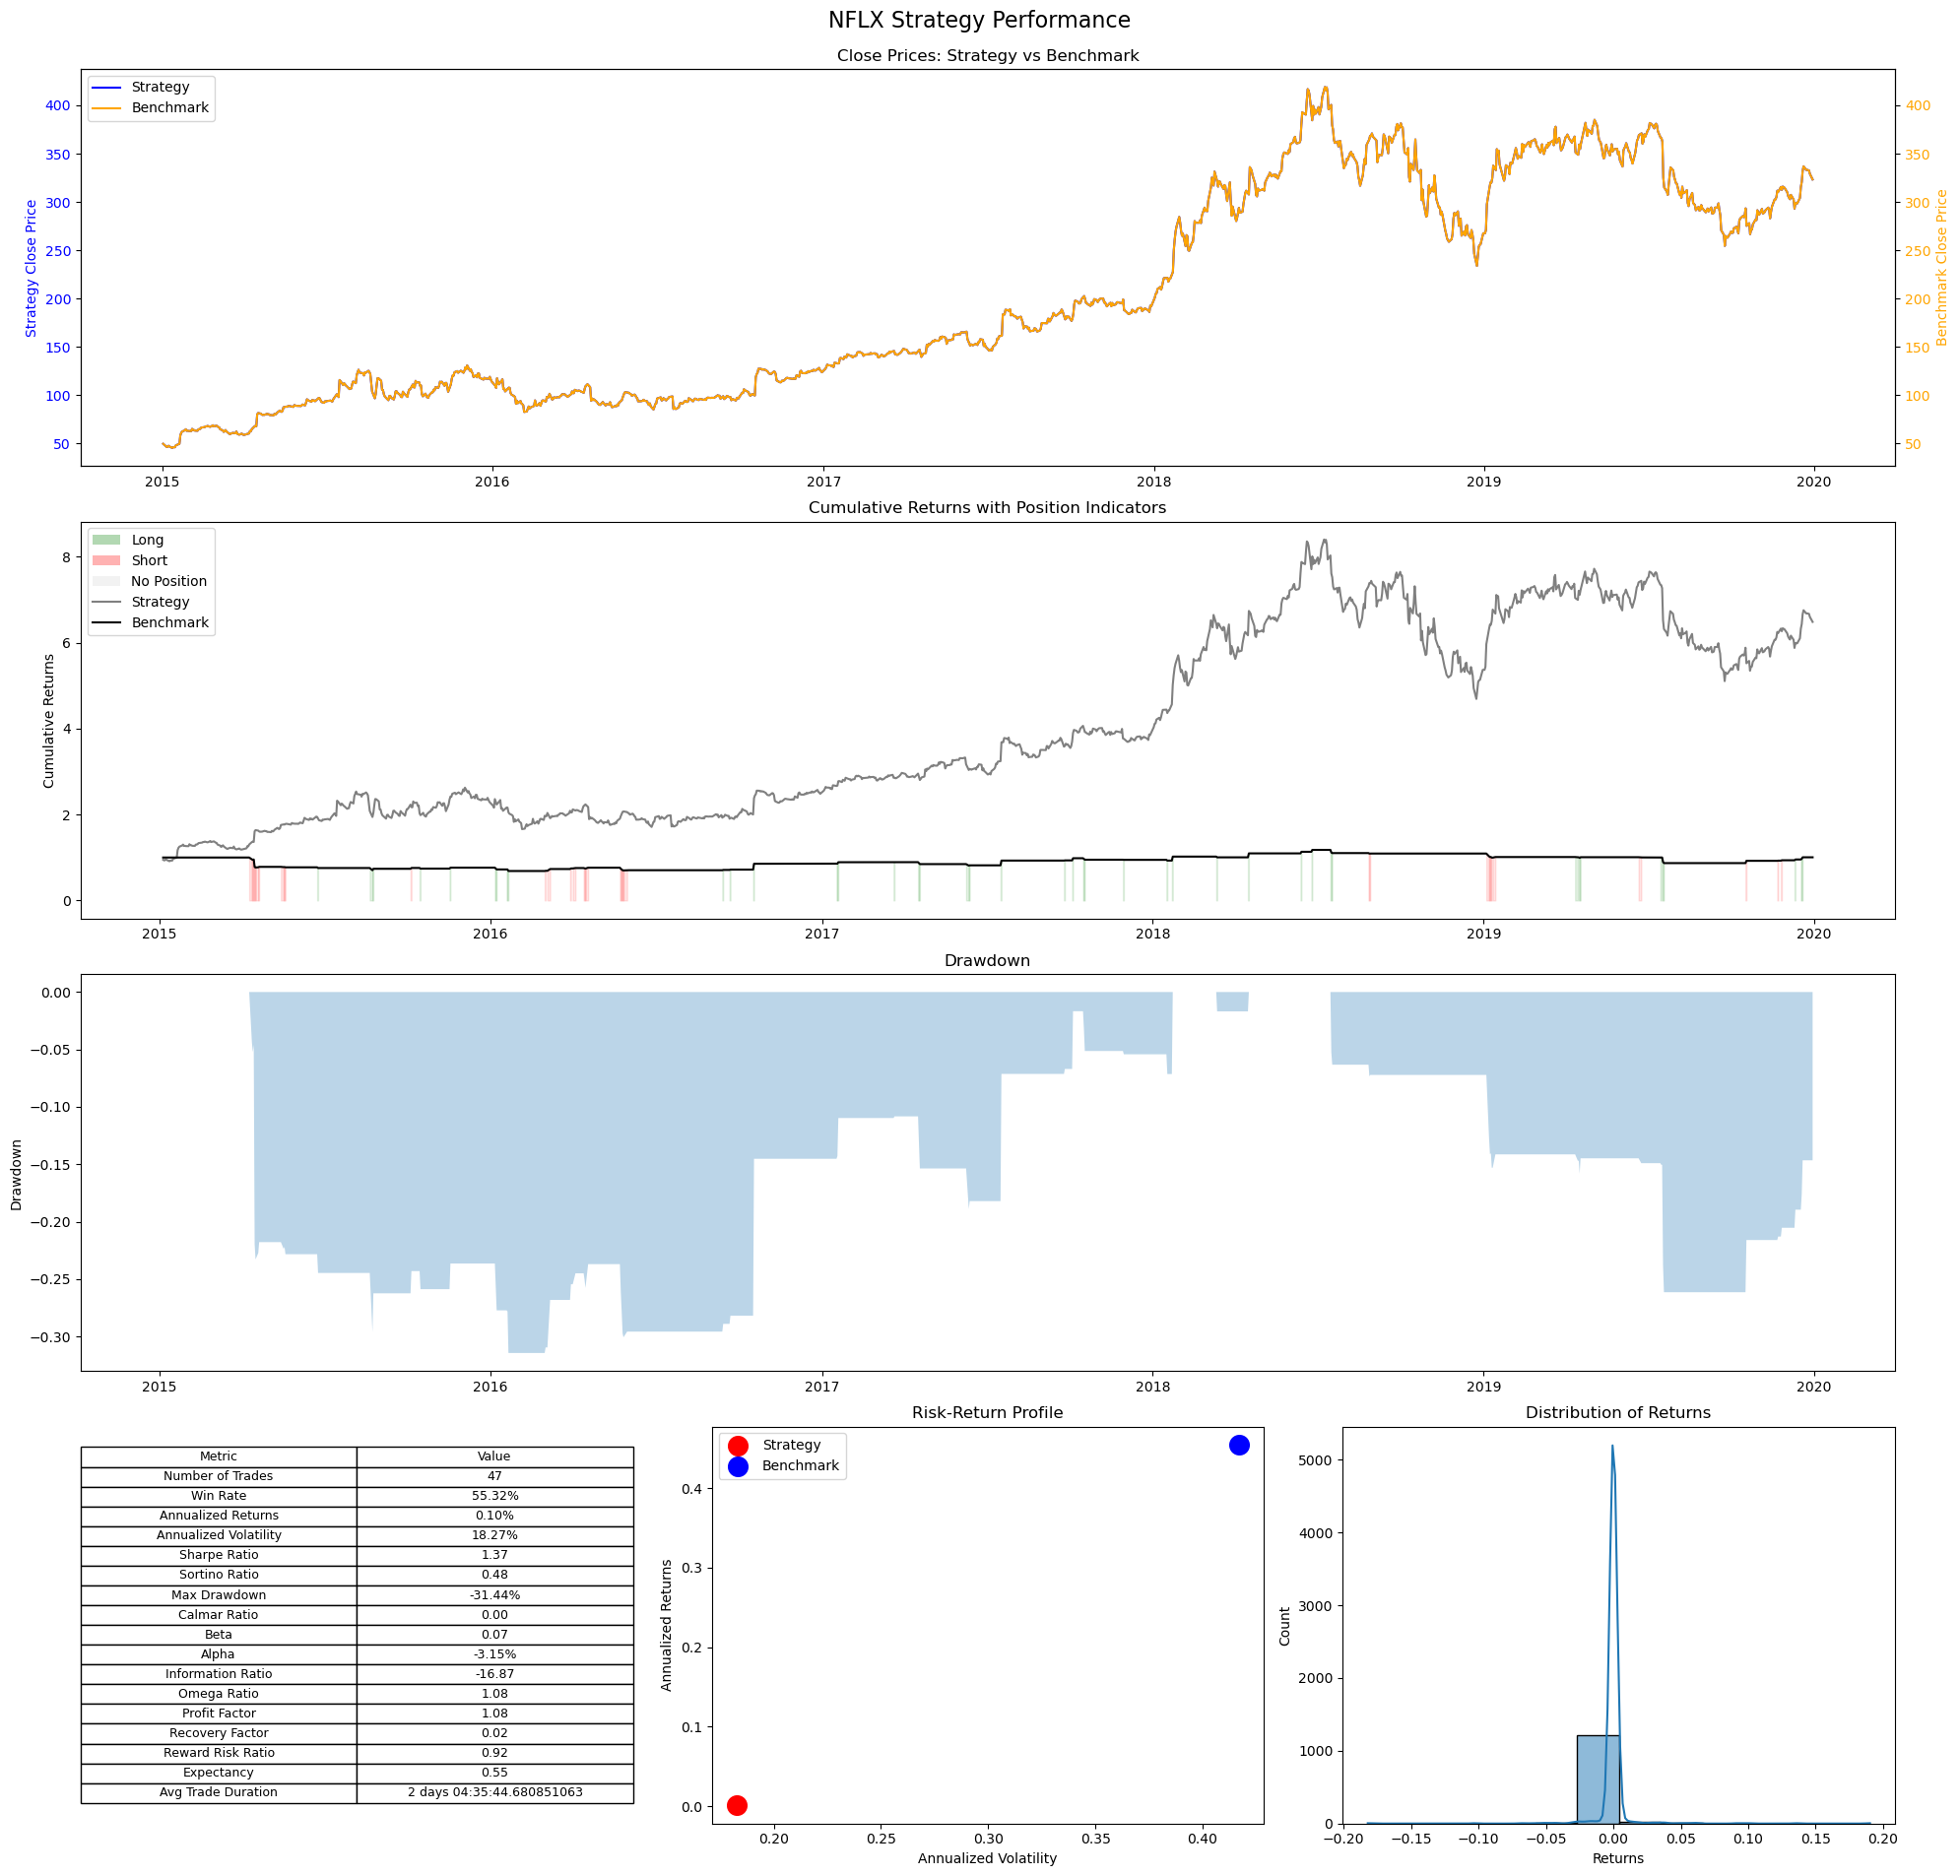

In [133]:
class YFinance_MF_Reversion_Strategy(YFinanceStrategy):
    def __init__(self, symbol: str, start_date: str, end_date: str, interval: str, params : dict, benchmark_symbol : str = "^GSPC", risk_free_rate : float = 0.0) -> None:
        super().__init__(symbol, start_date, end_date, interval, params, benchmark_symbol, risk_free_rate)

    def strategy(self):
        """
        1. Calculate Z Score
        2. Calculate Bollinger Bands
        3. Calculate Volume
        4. Caculate Short Term Moving Average and Long Term Moving Average
        5, Calculate Signal for each factor
        6. Generate Signal based on the combination of all factors
        """
        # Calculate Z Score
        self.data_strategy['MA'] = self.data_strategy['Close'].rolling(window=self.params['ma_window']).mean()
        self.data_strategy['STD'] = self.data_strategy['Close'].rolling(window=self.params['ma_window']).std()
        self.data_strategy['Z_score'] = (self.data_strategy['Close'] - self.data_strategy['MA']) / self.data_strategy['STD']

        # Calculate Bollinger Bands
        self.data_strategy['Upper_Band'] = self.data_strategy['MA'] + 2 * self.data_strategy['STD']
        self.data_strategy['Lower_Band'] = self.data_strategy['MA'] - 2 * self.data_strategy['STD']

        # Calculate Volume
        self.data_strategy['Volume_MA'] = self.data_strategy['Volume'].rolling(window=self.params['ma_window']).mean()
        self.data_strategy['Volume_STD'] = self.data_strategy['Volume'].rolling(window=self.params['ma_window']).std()
        self.data_strategy['Volume_Z'] = (self.data_strategy['Volume'] - self.data_strategy['Volume_MA']) / self.data_strategy['Volume_STD']

        # Trend following component
        self.data_strategy['MA_Short'] = self.data_strategy['Close'].rolling(window=self.params['ma_short']).mean()
        self.data_strategy['MA_Long'] = self.data_strategy['Close'].rolling(window=self.params['ma_long']).mean()

        # Signal 
        self.data_strategy['Trend'] = np.where(
            self.data_strategy['MA_Short'] > self.data_strategy['MA_Long'],
            1,
            -1
        )
        self.data_strategy['Z_score_Signal'] = np.where(
            self.data_strategy['Z_score'] < -self.params['z_threshold'],
            1, 
            np.where(
                self.data_strategy['Z_score'] > self.params['z_threshold'],
                -1, 
                0
            )
        )
        self.data_strategy['BB_Signal'] = np.where(
            self.data_strategy['Close'] < self.data_strategy['Lower_Band'],
            1,
            np.where(self.data_strategy['Close'] > self.data_strategy['Upper_Band'],
                -1,
                0
            )
        )
        self.data_strategy['Volume_Signal'] = np.where(
            self.data_strategy['Volume_Z'] > self.params['volume_threshold'],
            1,
            0
        )


        # signal generation
        self.data_strategy['signal'] = 0
        self.data_strategy['signal'] = np.where(
            (self.data_strategy['Trend'] == 1) & 
            (self.data_strategy['Z_score_Signal'] >= 0) & 
            (self.data_strategy['BB_Signal'] >= 0) & 
            (self.data_strategy['Volume_Signal'] == 1), 
            1, # buy signal
            np.where(
                (self.data_strategy['Trend'] == -1) & 
                (self.data_strategy['BB_Signal'] == -1) & 
                (self.data_strategy['Z_score_Signal'] == -1), 
                -1, # Sell Signal
                0 # Hold Signal
            )
        )

# Testing function on Netflix stock
mf_reversion_strategy_1 = YFinance_MF_Reversion_Strategy(
    symbol="NFLX",
    start_date = '2015-01-01',
    end_date = '2019-12-31',
    interval = '1d',
    params = {'ma_window' : 21, 'z_threshold': 2, 'volume_threshold': 2, "ma_short": 20, "ma_long": 100},
    benchmark_symbol='NFLX',
    risk_free_rate=0.0
)
mf_reversion_strategy_1.strategy()
mf_reversion_strategy_1.calculate_strategy_performance()
mf_reversion_strategy_1.plot_performance()

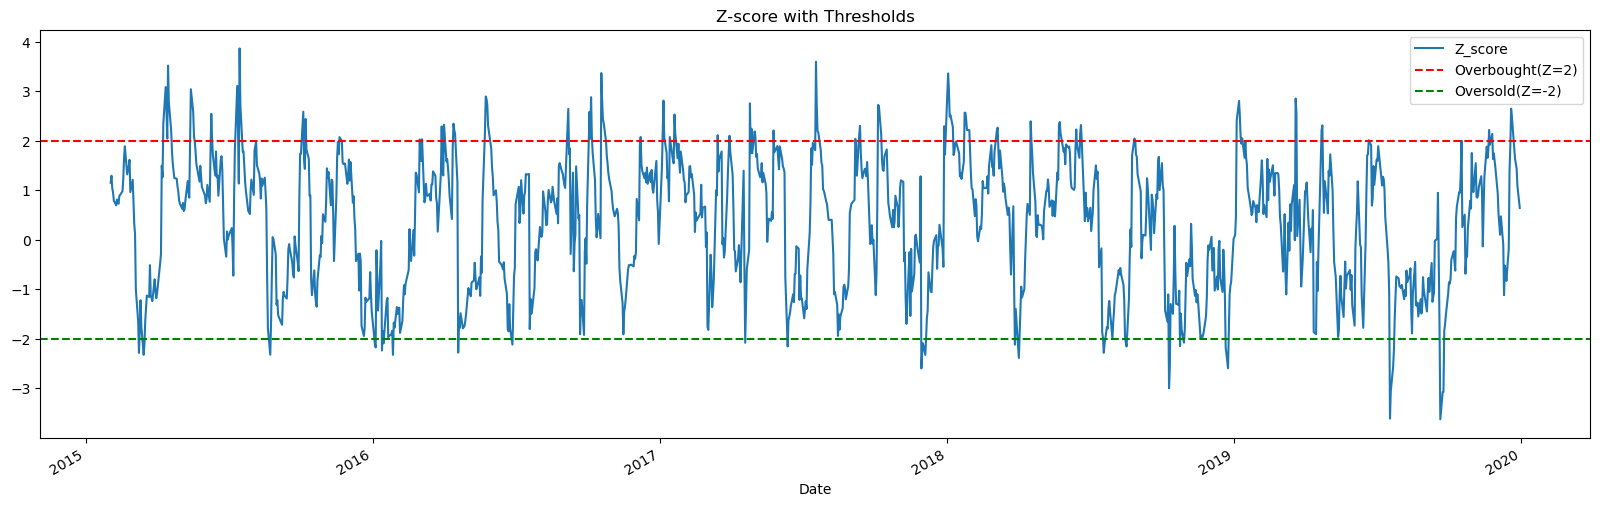

In [134]:
mf_reversion_strategy_1.data_strategy.plot(
    x='Date',
    y='Z_score',
    figsize=(20,6),
    title='Z-score with Thresholds'
)
plt.axhline(y=2, color='red', linestyle='--', label='Overbought(Z=2)')
plt.axhline(y=-2, color='green', linestyle='--', label='Oversold(Z=-2)')
plt.legend()
plt.show()

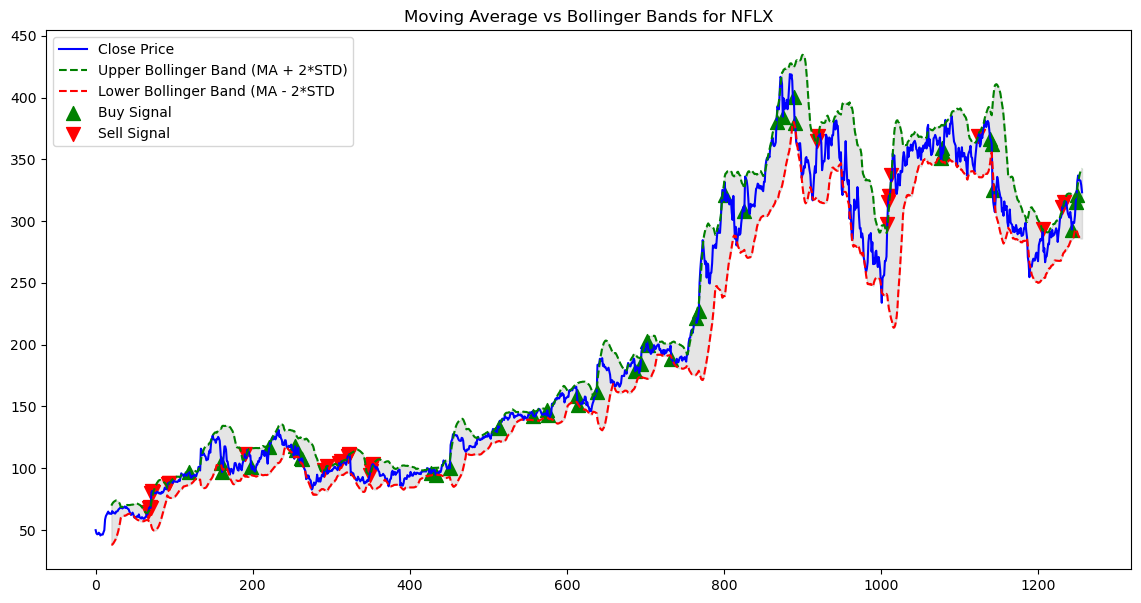

In [135]:
plt.figure(figsize=(14, 7))
plt.plot(mf_reversion_strategy_1.data_strategy.index, mf_reversion_strategy_1.data_strategy['Close'], label='Close Price', color='blue')
# Plot Bollinger Bands
plt.plot(mf_reversion_strategy_1.data_strategy.index, mf_reversion_strategy_1.data_strategy['Upper_Band'], label='Upper Bollinger Band (MA + 2*STD)', color='green', linestyle='--')
plt.plot(mf_reversion_strategy_1.data_strategy.index, mf_reversion_strategy_1.data_strategy['Lower_Band'], label='Lower Bollinger Band (MA - 2*STD', color='red', linestyle='--')
# Fill the Bollinger Band Area
plt.fill_between(mf_reversion_strategy_1.data_strategy.index, mf_reversion_strategy_1.data_strategy['Upper_Band'], mf_reversion_strategy_1.data_strategy['Lower_Band'], color='grey', alpha=0.2)
# Plot Buy Signals (Green Up Arrows)
plt.scatter(mf_reversion_strategy_1.data_strategy[mf_reversion_strategy_1.data_strategy['signal'] == 1].index, 
            mf_reversion_strategy_1.data_strategy['Close'][mf_reversion_strategy_1.data_strategy['signal'] == 1], 
            marker='^', color='g', s=100, label='Buy Signal')

# Plot Sell Signals (Red Down Arrows)
plt.scatter(mf_reversion_strategy_1.data_strategy[mf_reversion_strategy_1.data_strategy['signal'] == -1].index, 
            mf_reversion_strategy_1.data_strategy['Close'][mf_reversion_strategy_1.data_strategy['signal'] == -1], 
            marker='v', color='r', s=100, label='Sell Signal')
plt.title('Moving Average vs Bollinger Bands for NFLX')
plt.legend()
plt.show()

# Portfolio Optimization
optimise the portfolio based on our parameters:
- `ma_window`: Moving Average Window
- `z_threshold`: Threshold value for the price z-score
- `volume_threshold`: Threshold value for the volume z-score
- `ma_short`: Short Term Moving Average Window
- `ma_long`: Long Term Moving Average Window

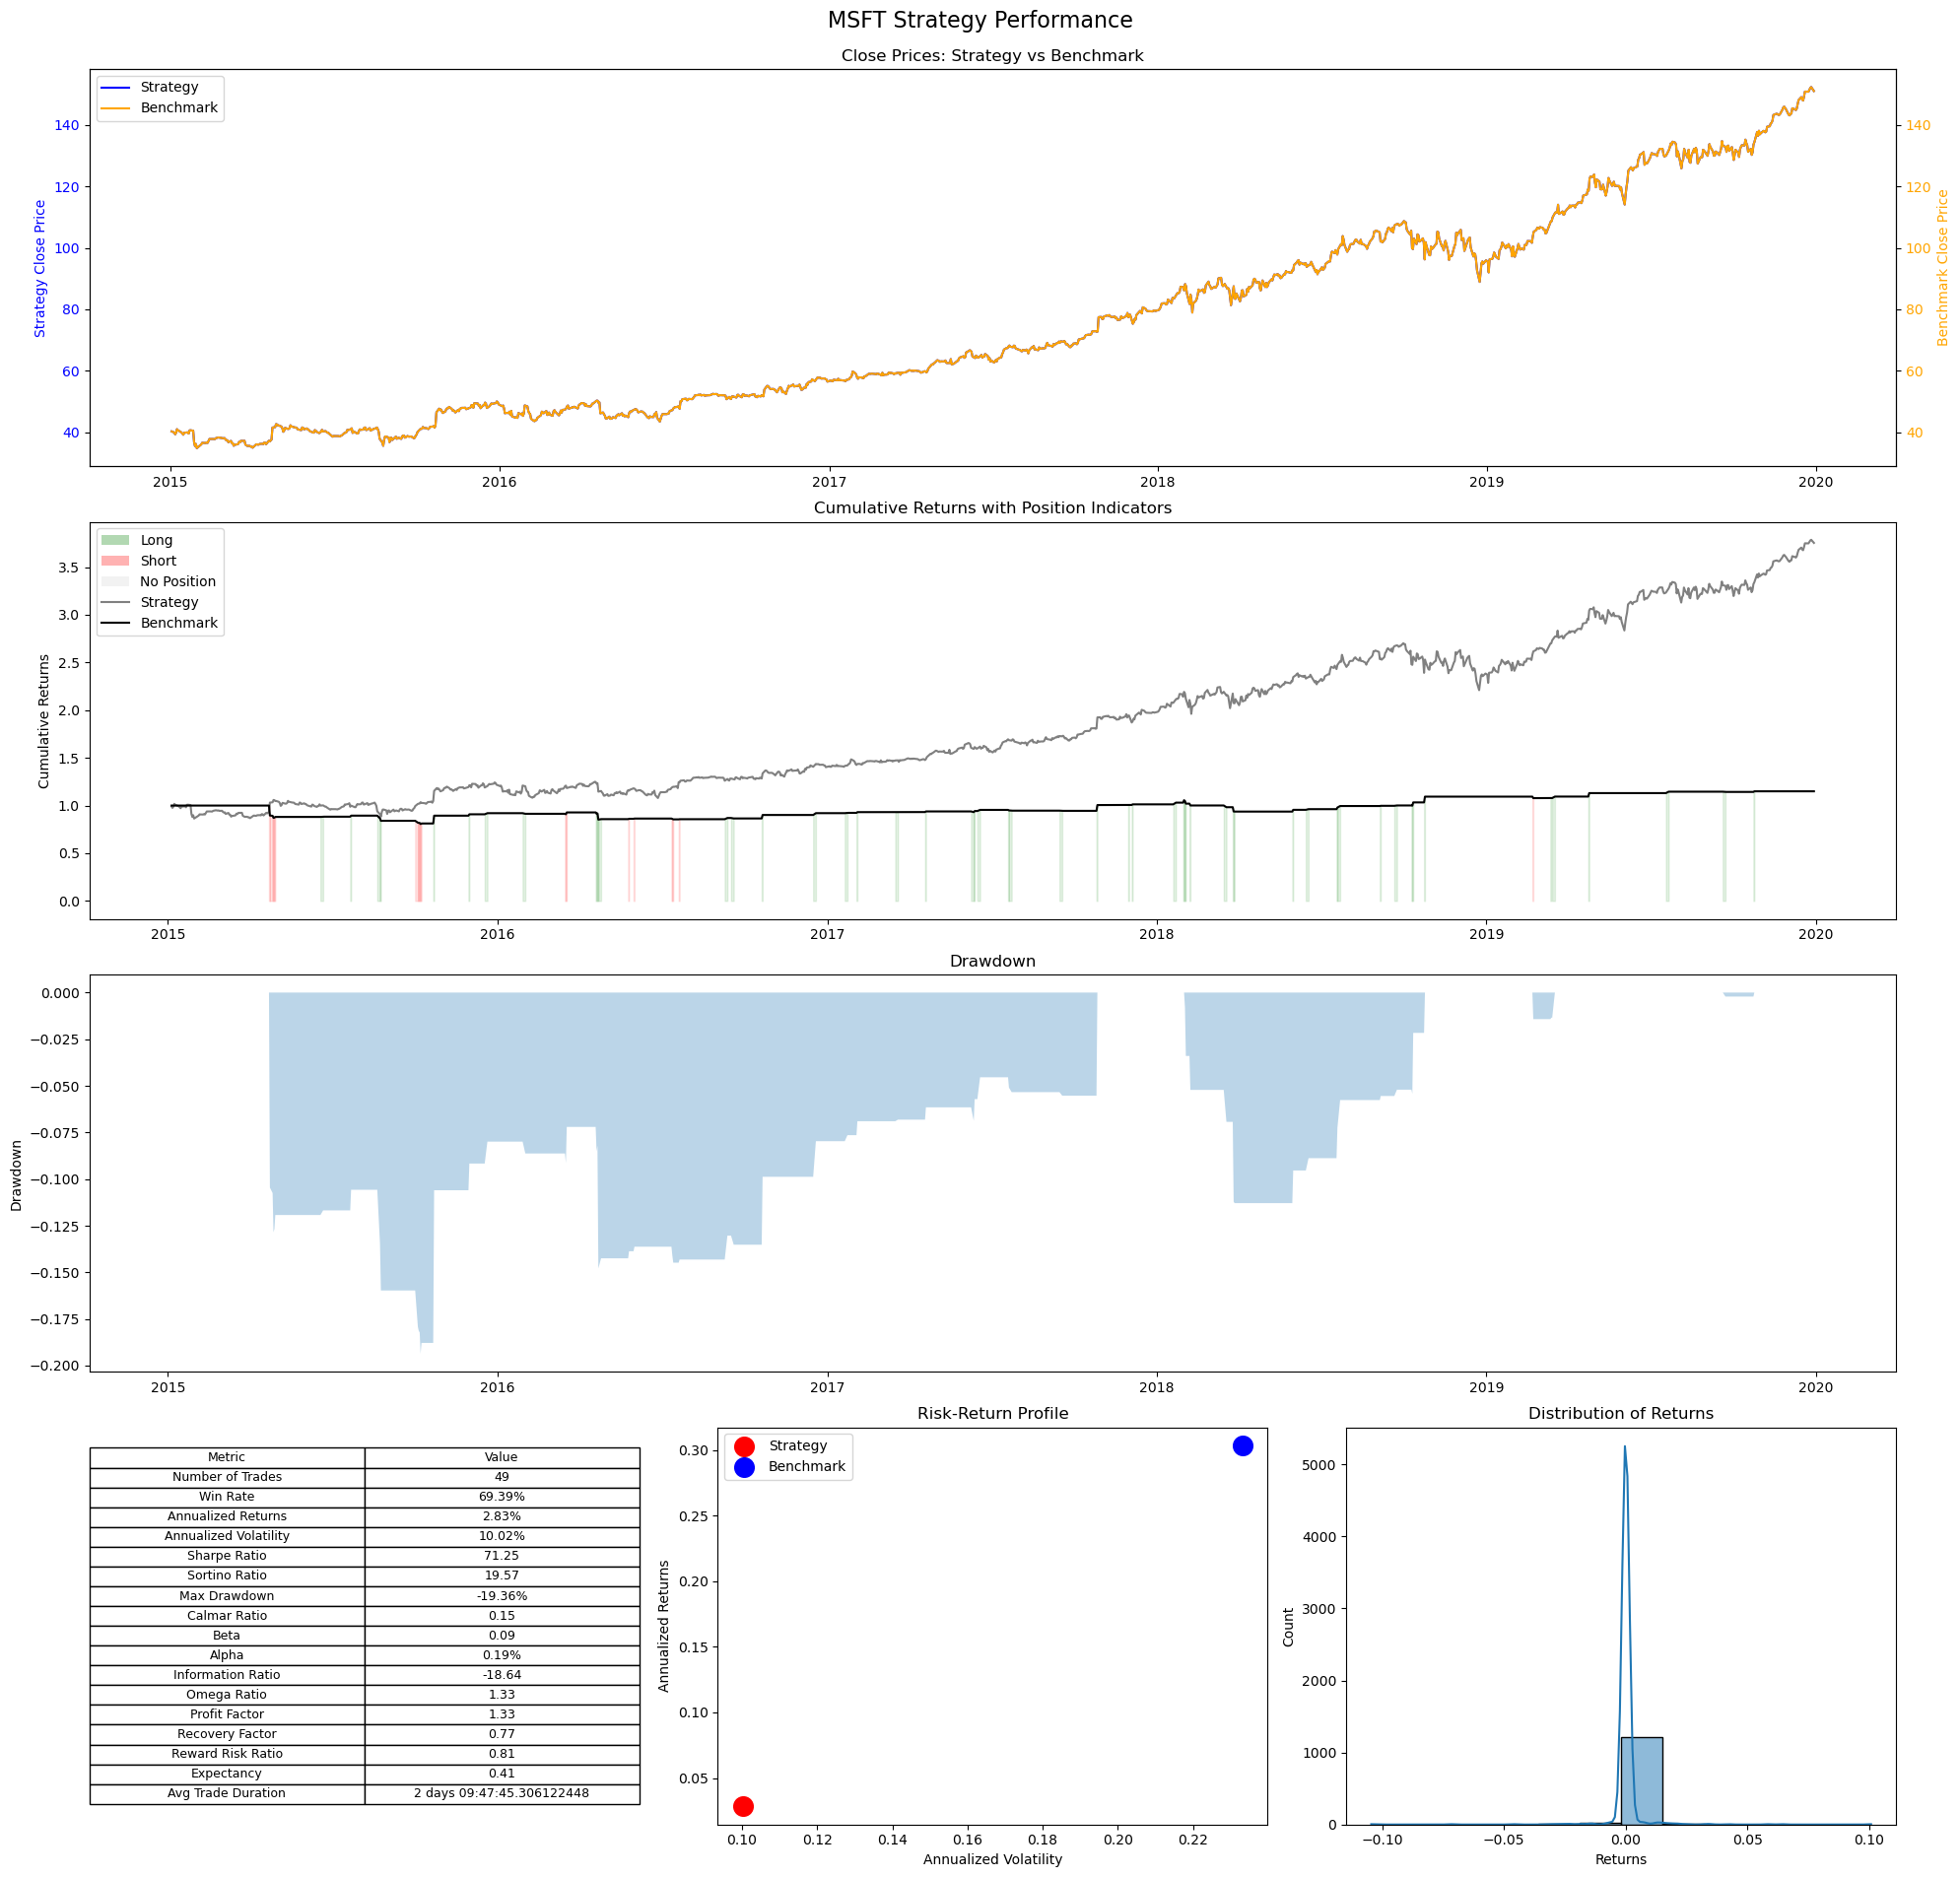

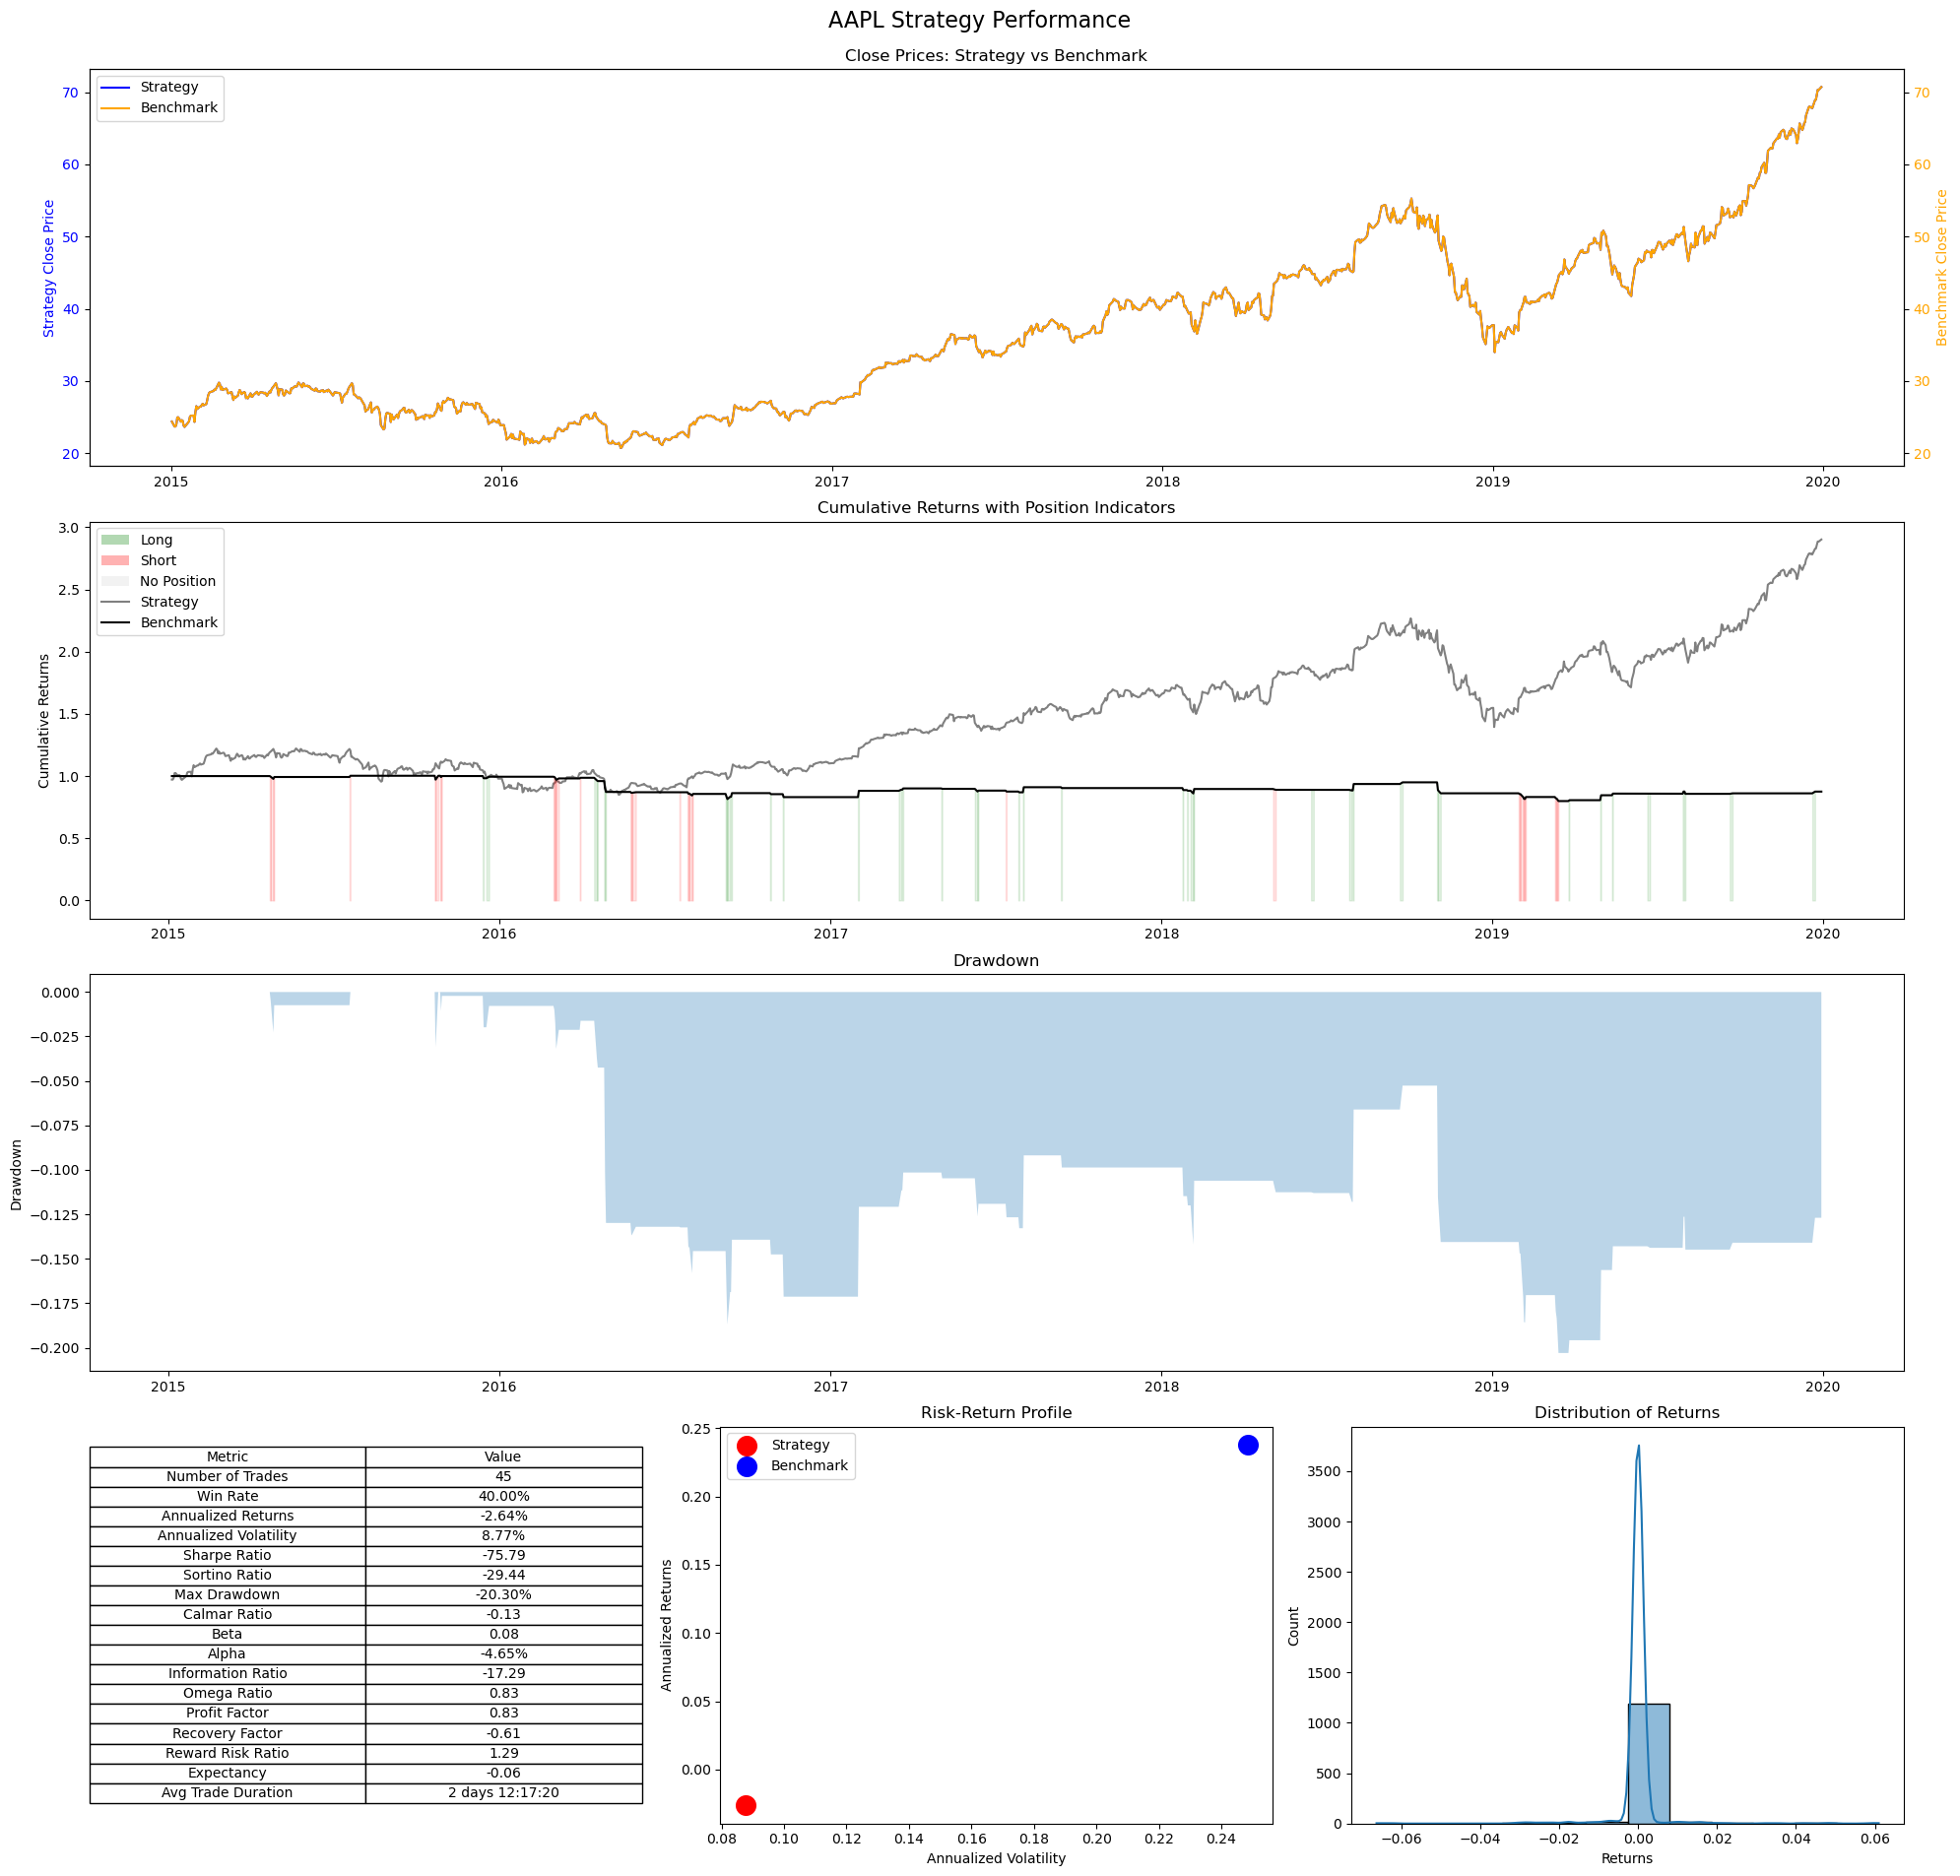

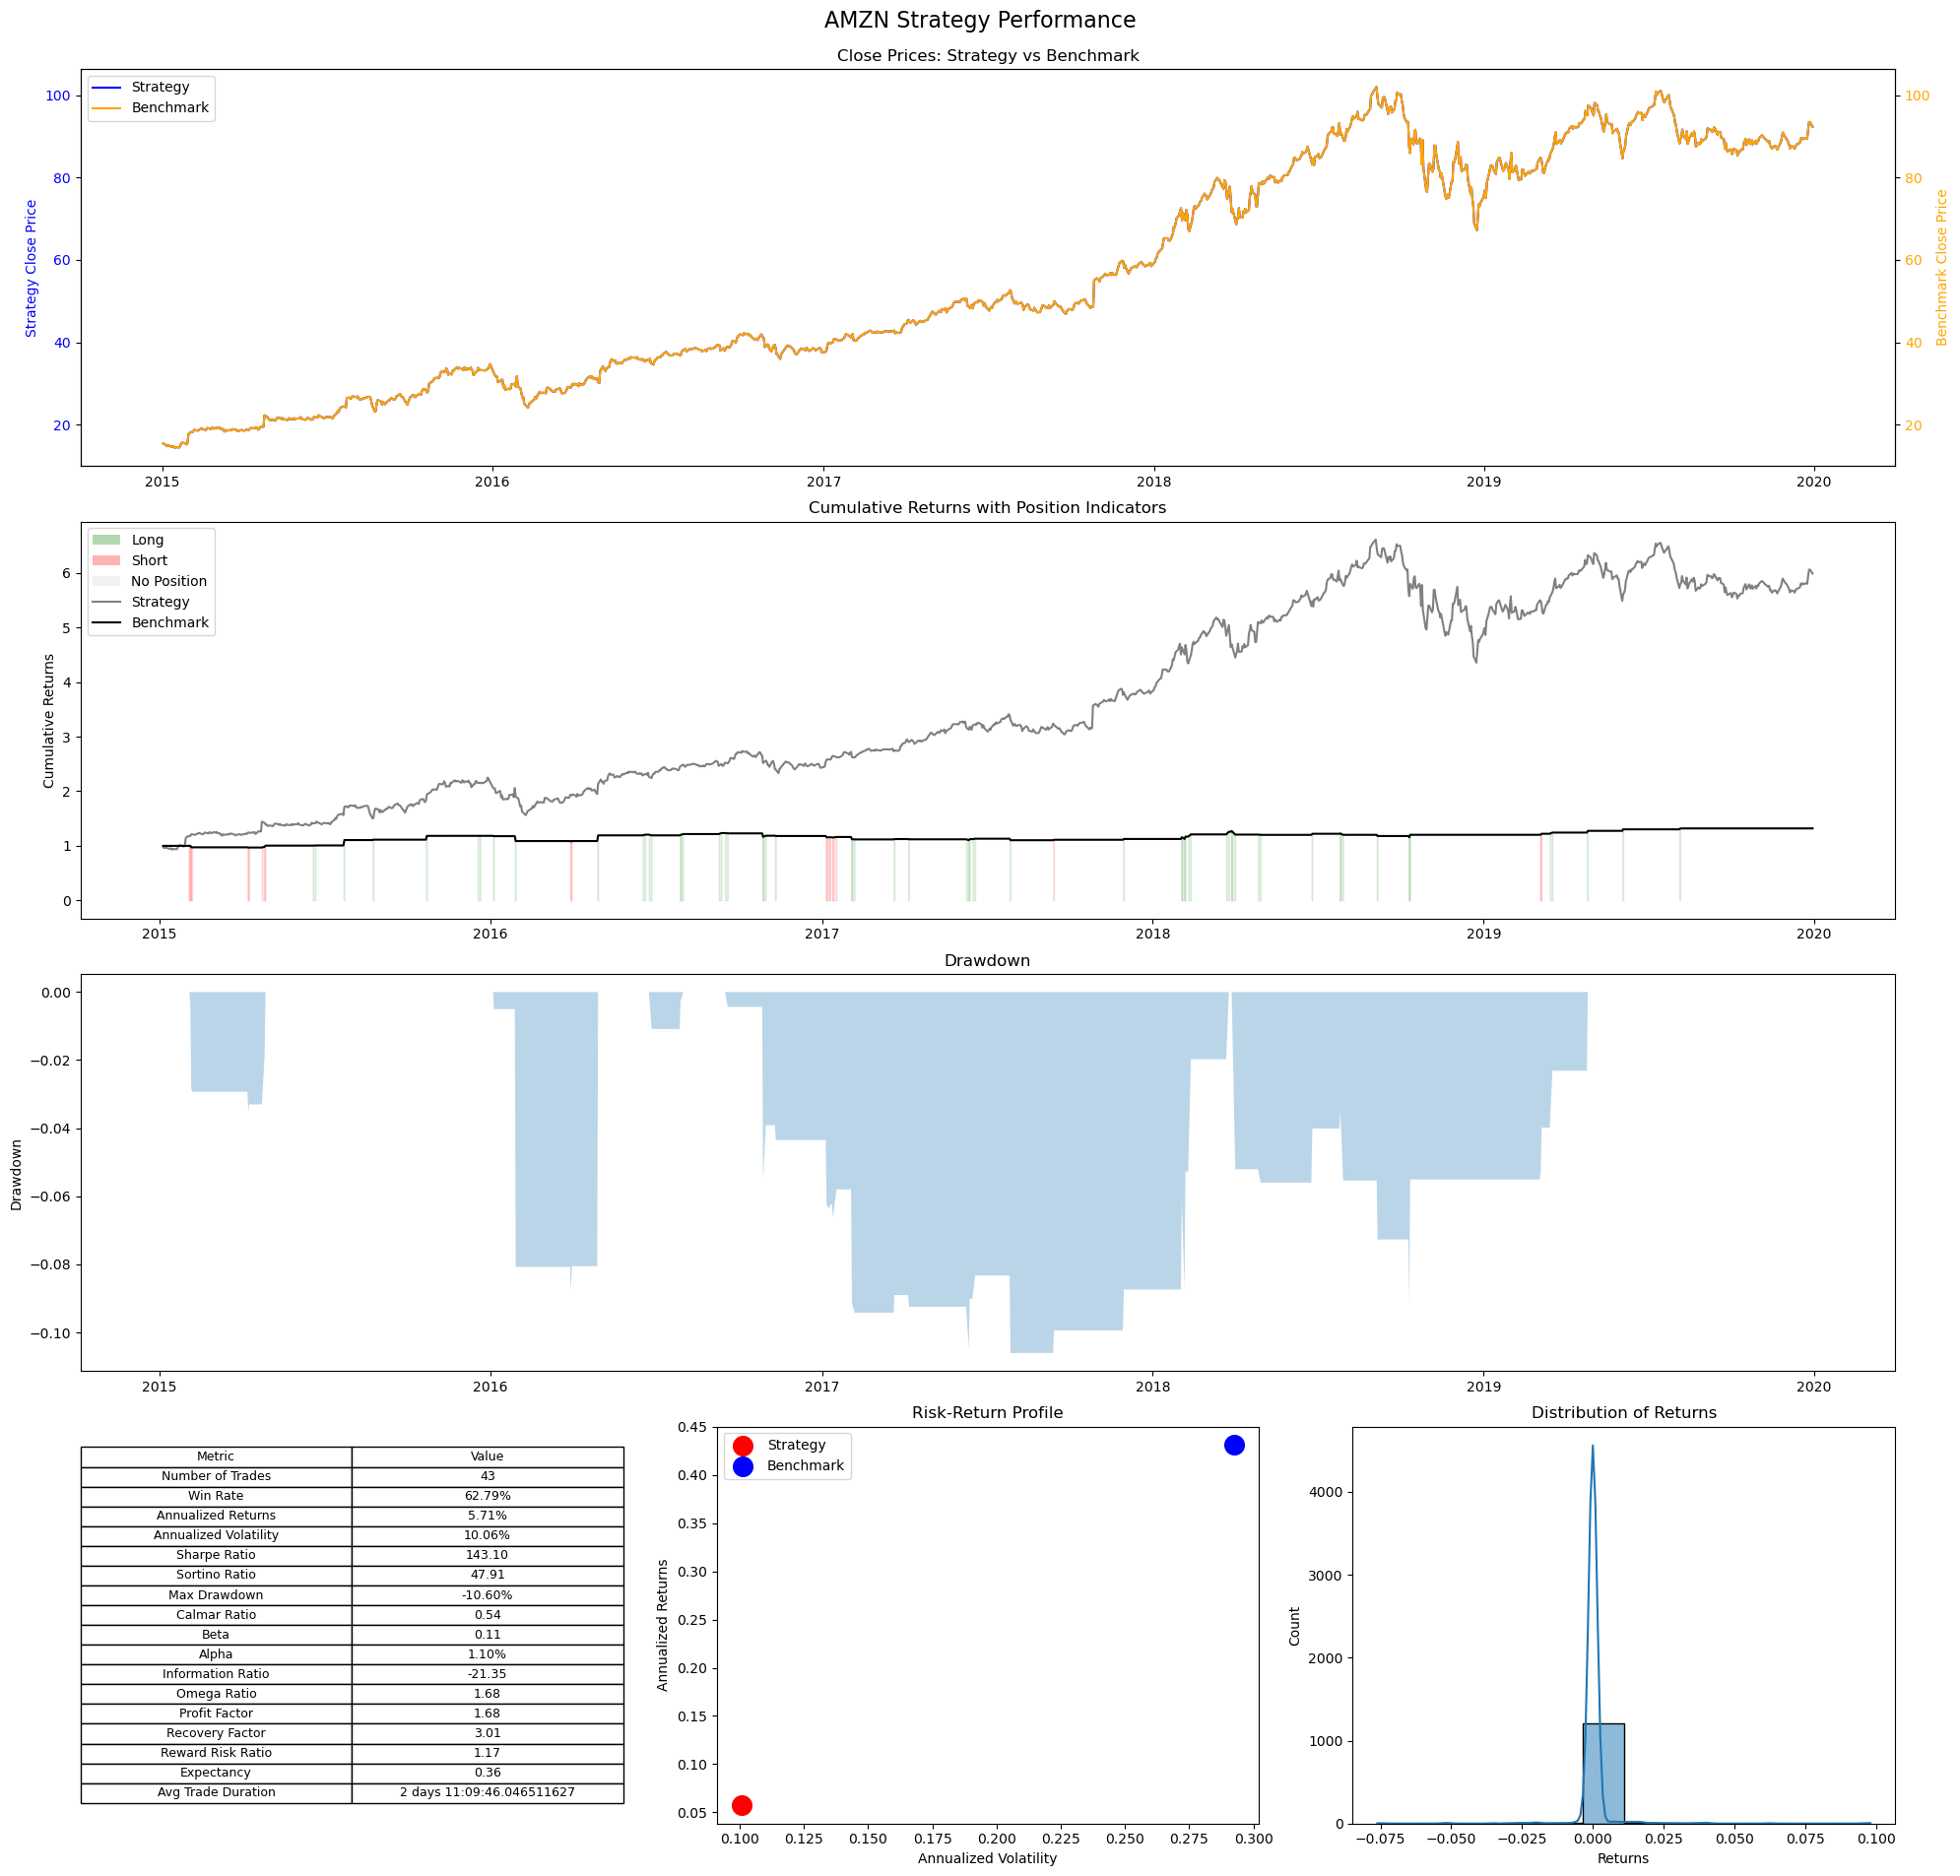

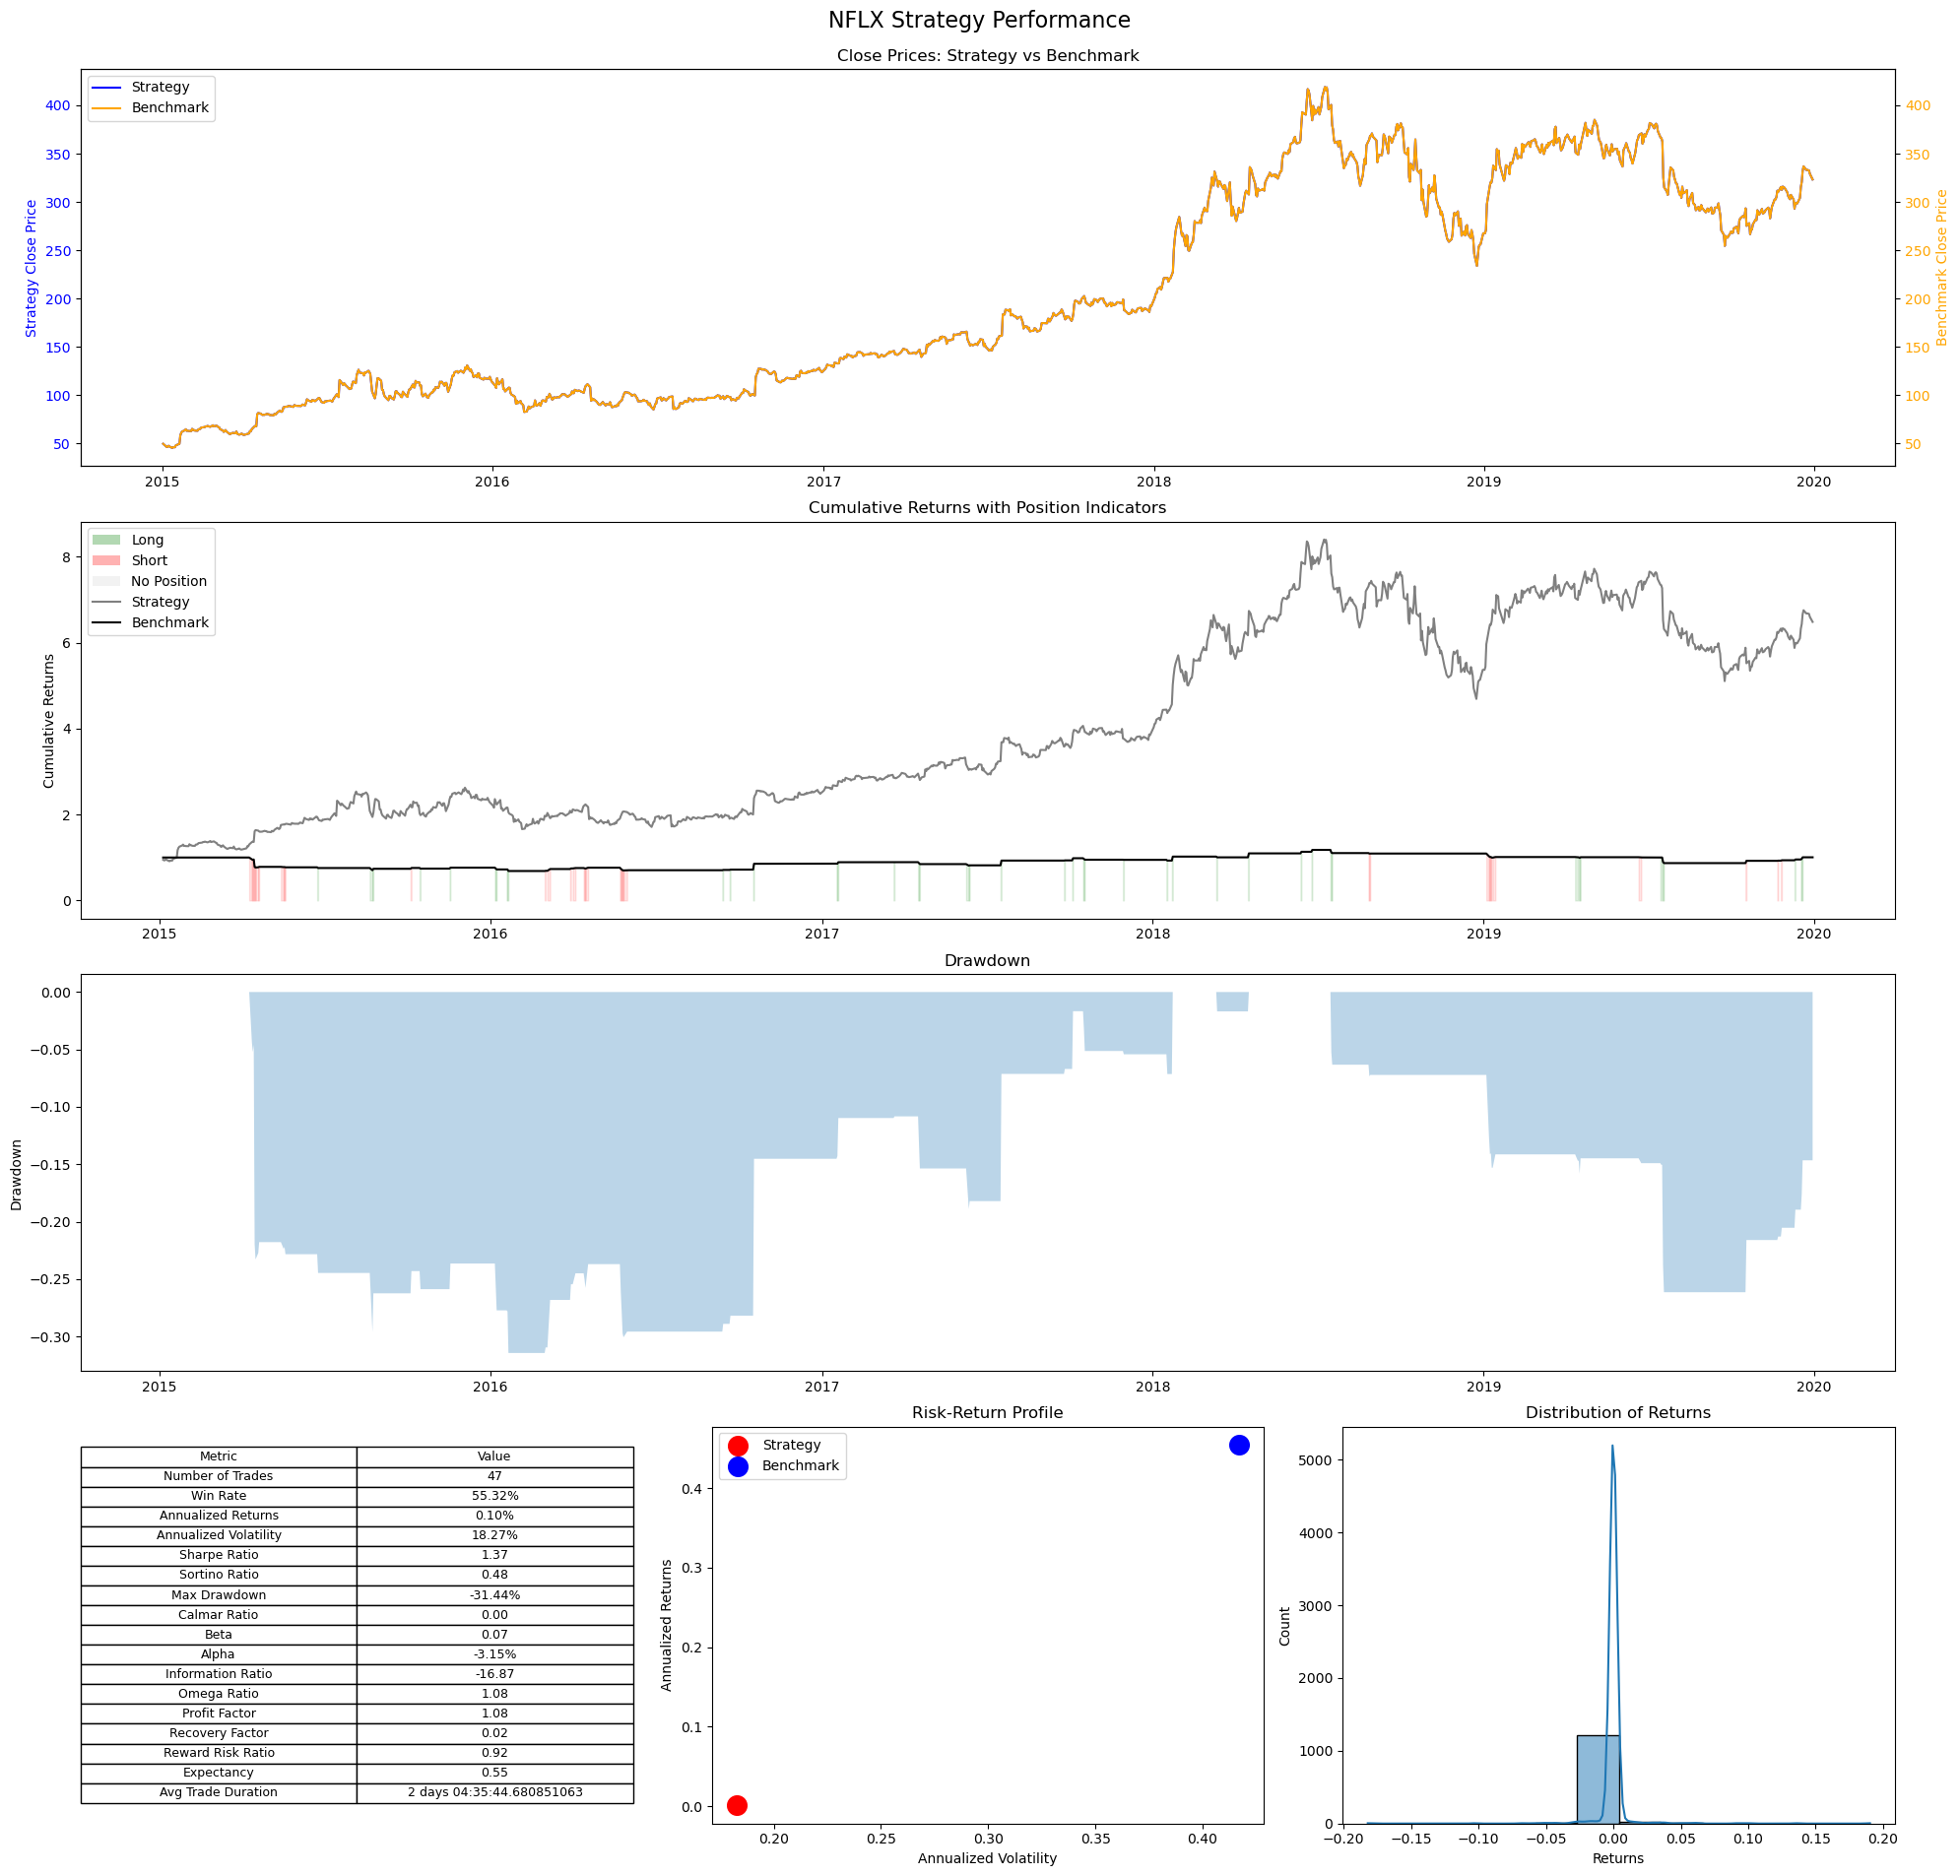

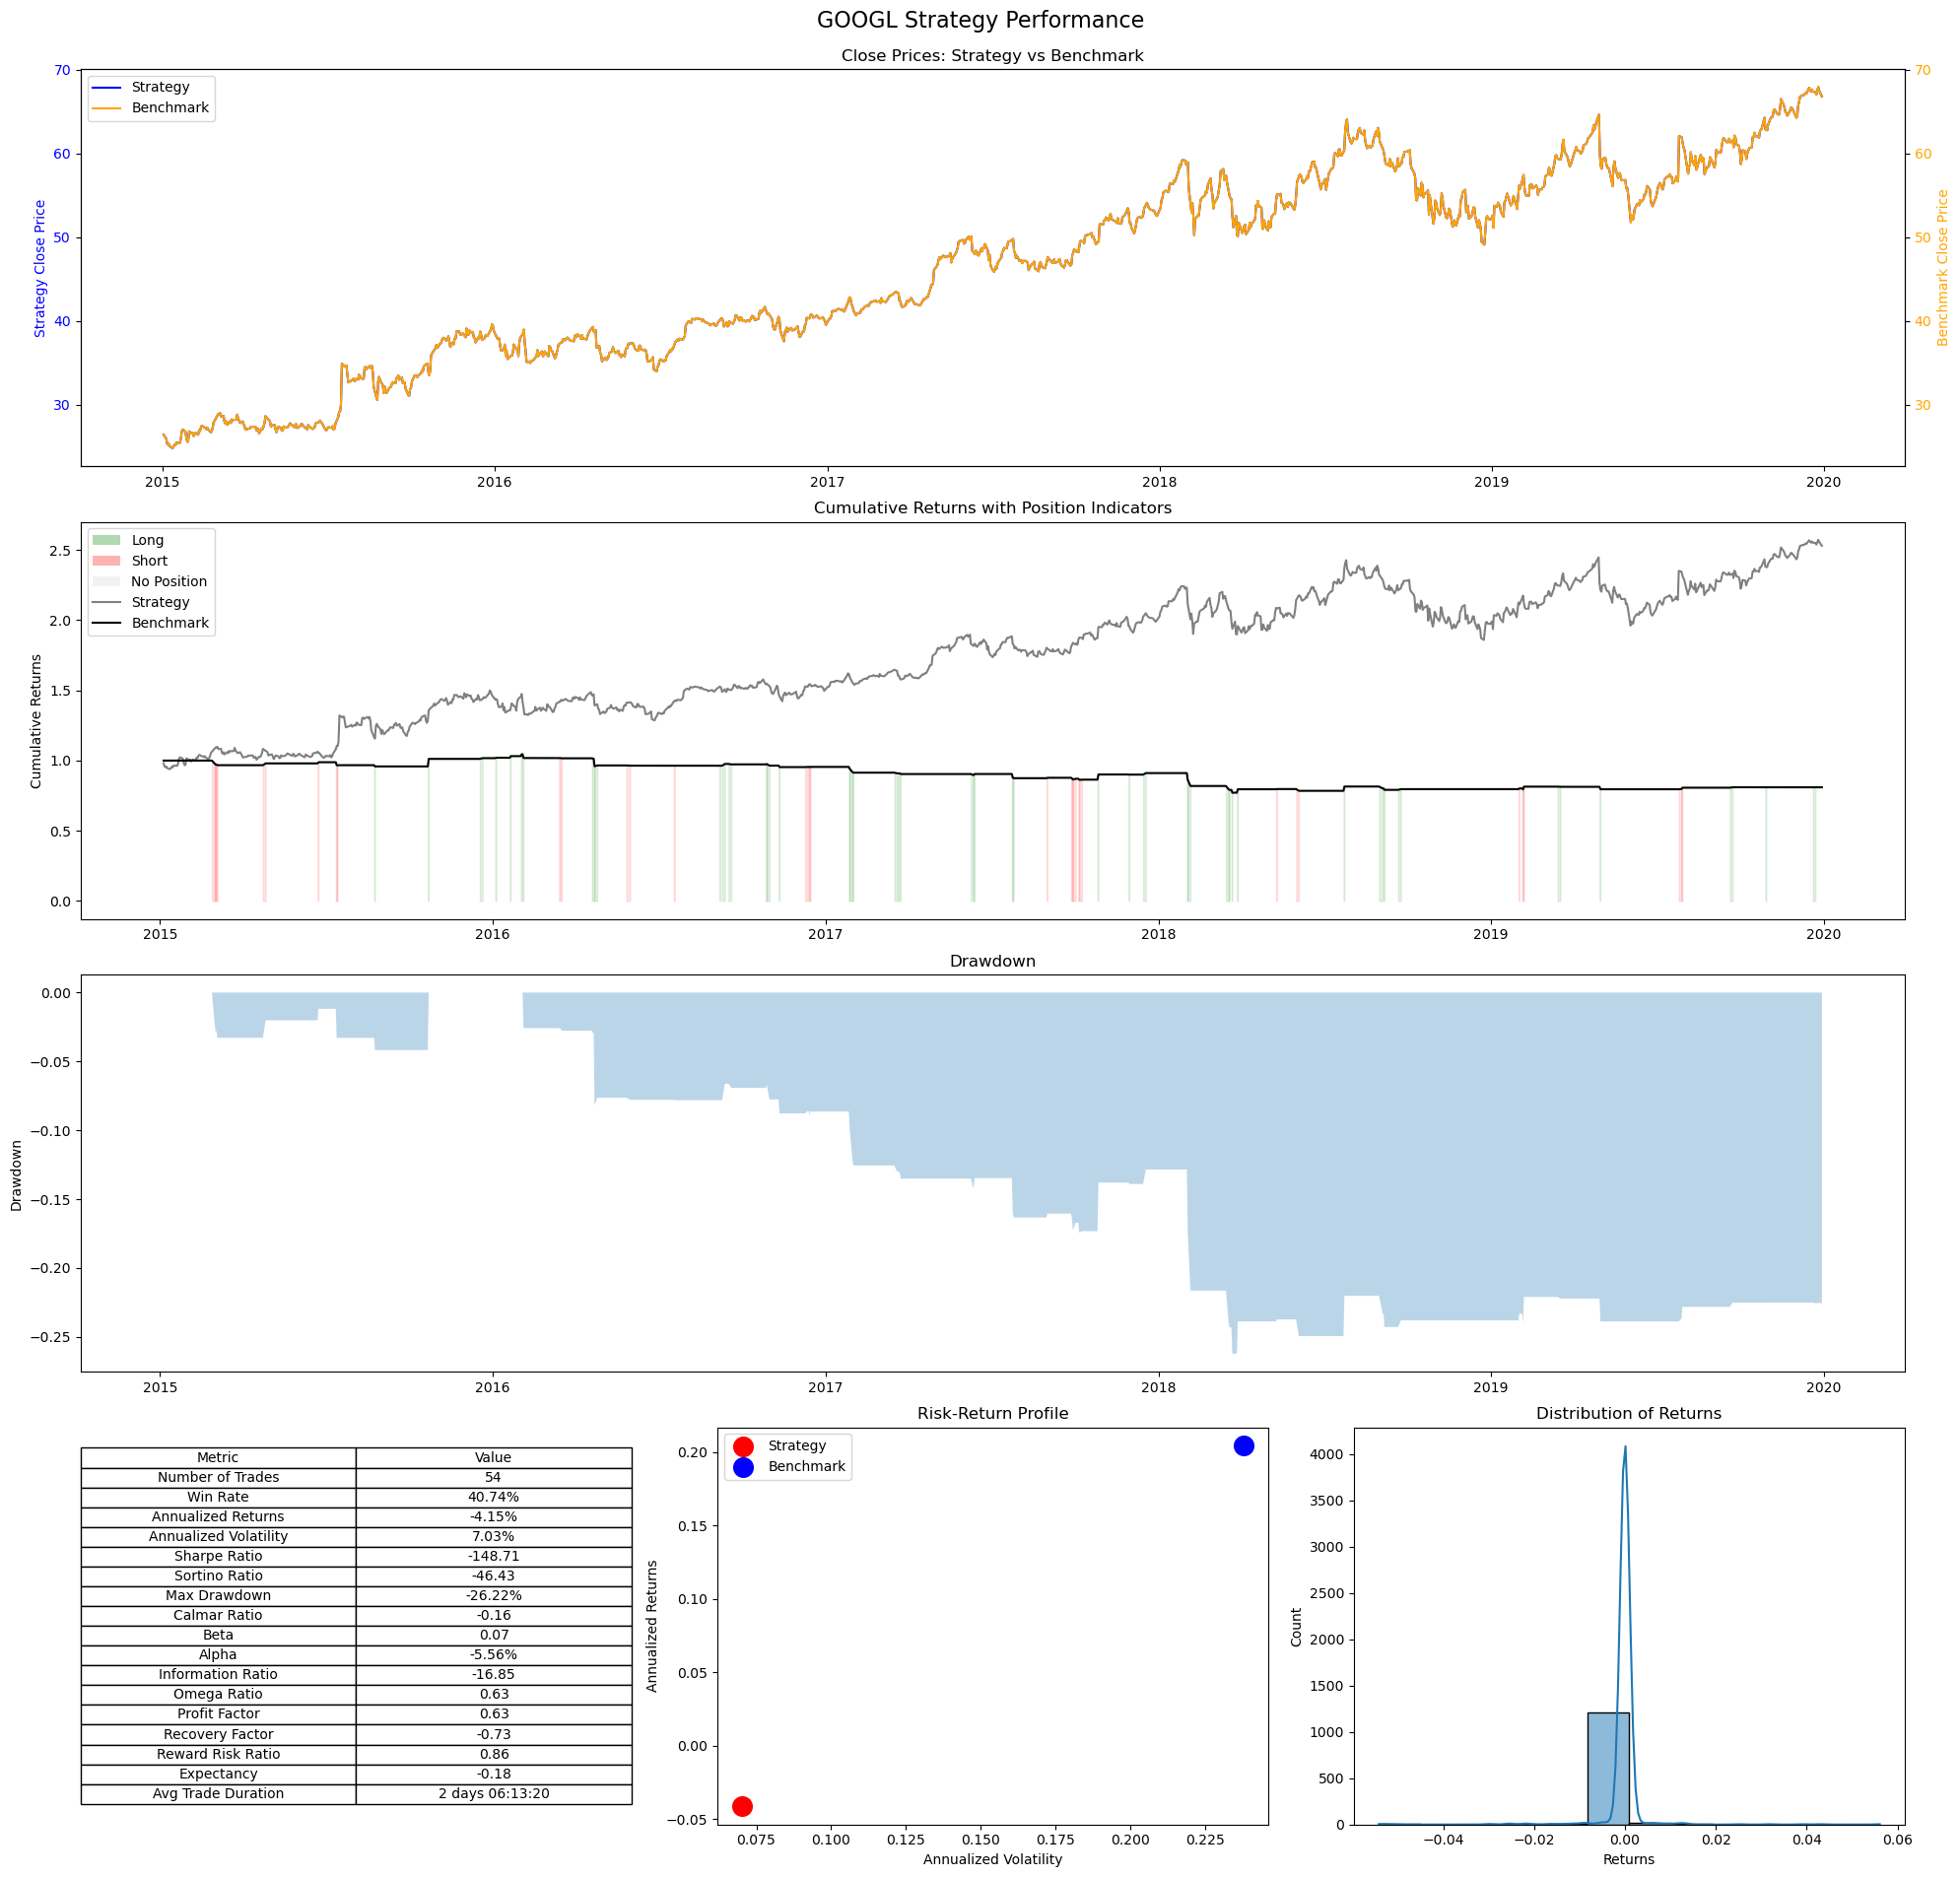

{'number_strategies': 5,
 'portfolio_annualized_return': 0.008152012447857349,
 'portfolio_annualized_volatility': 0.05565155540990937,
 'portfolio_sharpe_ratio': 0.146483101645813,
 'portfolio_sortino_ratio': 0.0721554461068367,
 'portfolio_max_drawdown': 0.09496441757611027,
 'portfolio_calmar_ratio': 0.0858428099274534,
 'benchmark_annualized_return': 0.3467814527369819,
 'benchmark_annualized_volatility': 0.2236249226968016,
 'benchmark_sharpe_ratio': 1.550728105592954,
 'benchmark_sortino_ratio': 1.5035291647375006,
 'benchmark_max_drawdown': 0.28895656049113133,
 'benchmark_calmar_ratio': 1.2001162117501927,
 'beta': 0.059089641942354026,
 'alpha': -0.01233917942662028,
 'annualized_treynor': 0.13796009215642552,
 'annualized_information': -1.4416494408917166,
 'omega_ratio': 1.0810865180094396,
 'profit_factor': 1.0810865180094396,
 'recovery_factor': 0.43485605378819675}

In [136]:
mf_reversion_list_strategies = []

for s in maang_stocks:
    strategy = YFinance_MF_Reversion_Strategy(
        symbol=s,
        start_date = '2015-01-01',
        end_date = '2019-12-31',
        interval = '1d',
        params = {'ma_window' : 21, 'z_threshold': 2, 'volume_threshold': 2, "ma_short": 20, "ma_long": 100},
        benchmark_symbol=s,
        risk_free_rate=0.0
    )
    strategy.strategy()
    strategy.calculate_strategy_performance()
    strategy.plot_performance()
    mf_reversion_list_strategies.append(strategy)

portfolio = YFinancePortfolio(mf_reversion_list_strategies)
portfolio.calculate_portfolio_performance()

In [137]:
portfolio.portfolio_performance

{'number_strategies': 5,
 'portfolio_annualized_return': 0.008152012447857349,
 'portfolio_annualized_volatility': 0.05565155540990937,
 'portfolio_sharpe_ratio': 0.146483101645813,
 'portfolio_sortino_ratio': 0.0721554461068367,
 'portfolio_max_drawdown': 0.09496441757611027,
 'portfolio_calmar_ratio': 0.0858428099274534,
 'benchmark_annualized_return': 0.3467814527369819,
 'benchmark_annualized_volatility': 0.2236249226968016,
 'benchmark_sharpe_ratio': 1.550728105592954,
 'benchmark_sortino_ratio': 1.5035291647375006,
 'benchmark_max_drawdown': 0.28895656049113133,
 'benchmark_calmar_ratio': 1.2001162117501927,
 'beta': 0.059089641942354026,
 'alpha': -0.01233917942662028,
 'annualized_treynor': 0.13796009215642552,
 'annualized_information': -1.4416494408917166,
 'omega_ratio': 1.0810865180094396,
 'profit_factor': 1.0810865180094396,
 'recovery_factor': 0.43485605378819675}

In [138]:
from itertools import product
ma_window = [14, 21, 30]
threshold = [1.0, 1.5, 2.0, 3.0]
volume_threshold = [0.5, 1.0, 1.5, 2.0]
ma_short = [10, 20, 30]
ma_long = [50, 100, 150]

optimization_parameters = product(ma_window, threshold, volume_threshold, ma_short, ma_long)

portfolio_optimization = []

for wind, z_thresh, vol_thresh, ma_short, ma_long in optimization_parameters:
    temp_list_strategies = []
    for s in maang_stocks:
        strategy = YFinance_MF_Reversion_Strategy(
            symbol=s,
            start_date = '2015-01-01',
            end_date = '2019-12-31',
            interval = '1d',
            params = {'ma_window' : wind, 'z_threshold': z_thresh, 'volume_threshold': vol_thresh, "ma_short": ma_short, "ma_long": ma_long}, 
            benchmark_symbol=s,
            risk_free_rate=0.0
        )
        strategy.strategy()
        strategy.calculate_strategy_performance()
        temp_list_strategies.append(strategy)
    temp_portfolio = YFinancePortfolio(temp_list_strategies)
    temp_portfolio.calculate_portfolio_performance()
    temp_portfolio.portfolio_performance.update({
        'ma_window' : wind,
        'z_threshold': z_thresh,
        'volume_threshold': vol_thresh,
        "ma_short": ma_short,
        "ma_long": ma_long
        }
    )
    portfolio_optimization.append(temp_portfolio.portfolio_performance)
    print(f"""Testing for ma_window:{wind}, z_threshold: {z_thresh}, volume_threshold: {vol_thresh}, ma_short: {ma_short}, ma_long: {ma_long}""")
portfolio_optimization

Testing for ma_window:14, z_threshold: 1.0, volume_threshold: 0.5, ma_short: 10, ma_long: 50
Testing for ma_window:14, z_threshold: 1.0, volume_threshold: 0.5, ma_short: 10, ma_long: 100
Testing for ma_window:14, z_threshold: 1.0, volume_threshold: 0.5, ma_short: 10, ma_long: 150
Testing for ma_window:14, z_threshold: 1.0, volume_threshold: 0.5, ma_short: 20, ma_long: 50
Testing for ma_window:14, z_threshold: 1.0, volume_threshold: 0.5, ma_short: 20, ma_long: 100
Testing for ma_window:14, z_threshold: 1.0, volume_threshold: 0.5, ma_short: 20, ma_long: 150
Testing for ma_window:14, z_threshold: 1.0, volume_threshold: 0.5, ma_short: 30, ma_long: 50
Testing for ma_window:14, z_threshold: 1.0, volume_threshold: 0.5, ma_short: 30, ma_long: 100
Testing for ma_window:14, z_threshold: 1.0, volume_threshold: 0.5, ma_short: 30, ma_long: 150
Testing for ma_window:14, z_threshold: 1.0, volume_threshold: 1.0, ma_short: 10, ma_long: 50
Testing for ma_window:14, z_threshold: 1.0, volume_threshold: 1.

[{'number_strategies': 5,
  'portfolio_annualized_return': 0.04722475646754587,
  'portfolio_annualized_volatility': 0.0727526767093388,
  'portfolio_sharpe_ratio': 0.6491136629407881,
  'portfolio_sortino_ratio': 0.40337986237576956,
  'portfolio_max_drawdown': 0.08780535520656044,
  'portfolio_calmar_ratio': 0.5378345814608975,
  'benchmark_annualized_return': 0.3467814527369819,
  'benchmark_annualized_volatility': 0.2236249226968016,
  'benchmark_sharpe_ratio': 1.550728105592954,
  'benchmark_sortino_ratio': 1.5035291647375006,
  'benchmark_max_drawdown': 0.28895656049113133,
  'benchmark_calmar_ratio': 1.2001162117501927,
  'beta': 0.15158153407715907,
  'alpha': -0.005340908127831681,
  'annualized_treynor': 0.3115468962301648,
  'annualized_information': -1.3677967249686824,
  'omega_ratio': 1.273648798738449,
  'profit_factor': 1.2736487987384488,
  'recovery_factor': 2.944942103917981,
  'ma_window': 14,
  'z_threshold': 1.0,
  'volume_threshold': 0.5,
  'ma_short': 10,
  'ma_

# Performance Analysis

In [145]:
# sorting by sharpe ratio in ascending order
df_portfolio_optimization = pd.DataFrame(portfolio_optimization).sort_values('portfolio_sharpe_ratio', ascending=False)
df_portfolio_optimization

number_strategies  portfolio_annualized_return  \
255                  5                     0.076121   
252                  5                     0.066860   
258                  5                     0.069001   
259                  5                     0.068100   
108                  5                     0.061853   
..                 ...                          ...   
175                  5                    -0.017361   
169                  5                    -0.023455   
176                  5                    -0.025279   
179                  5                    -0.026674   
178                  5                    -0.028248   

     portfolio_annualized_volatility  portfolio_sharpe_ratio  \
255                         0.088925                0.856005   
252                         0.084303                0.793095   
258                         0.089450                0.771396   
259                         0.090384                0.753450   
108                         0.083714                0.738859   
..                               ...                     ...   
175                         0.045896               -0.378264   
169                         0.055671               -0.421320   
176                         0.052337               -0.483014   
179                         0.053089               -0.502450   
178                         0.048697               -0.580075   

     portfolio_sortino_ratio  portfolio_max_drawdown  portfolio_calmar_ratio  \
255                 0.570120                0.099667                0.763746   
252                 0.520382                0.091904                0.727496   
258                 0.505452                0.108580                0.635486   
259                 0.487996                0.116526                0.584420   
108                 0.507098                0.088506                0.698859   
..                       ...                     ...                     ...   
175                -0.153501                0.137330               -0.126417   
169                -0.190674                0.179569               -0.130619   
176                -0.199197                0.172022               -0.146955   
179                -0.207082                0.167868               -0.158900   
178                -0.234434                0.172247               -0.163998   

     benchmark_annualized_return  benchmark_annualized_volatility  \
255                     0.346781                         0.223625   
252                     0.346781                         0.223625   
258                     0.346781                         0.223625   
259                     0.346781                         0.223625   
108                     0.346781                         0.223625   
..                           ...                              ...   
175                     0.346781                         0.223625   
169                     0.346781                         0.223625   
176                     0.346781                         0.223625   
179                     0.346781                         0.223625   
178                     0.346781                         0.223625   

     benchmark_sharpe_ratio  ...  annualized_treynor  annualized_information  \
255                1.550728  ...            0.329758               -1.315503   
252                1.550728  ...            0.321552               -1.335694   
258                1.550728  ...            0.298852               -1.349111   
259                1.550728  ...            0.291300               -1.355485   
108                1.550728  ...            0.294169               -1.366864   
..                      ...  ...                 ...                     ...   
175                1.550728  ...           -0.499330               -1.538591   
169                1.550728  ...           -0.409744               -1.585094   
176                1.550728  ...           -0.670256             

In [147]:
# sorting by annualized returns in ascending order
df_portfolio_optimization = pd.DataFrame(portfolio_optimization).sort_values('portfolio_annualized_return', ascending=False)
df_portfolio_optimization

number_strategies  portfolio_annualized_return  \
255                  5                     0.076121   
258                  5                     0.069001   
259                  5                     0.068100   
252                  5                     0.066860   
111                  5                     0.062512   
..                 ...                          ...   
169                  5                    -0.023455   
160                  5                    -0.023691   
176                  5                    -0.025279   
179                  5                    -0.026674   
178                  5                    -0.028248   

     portfolio_annualized_volatility  portfolio_sharpe_ratio  \
255                         0.088925                0.856005   
258                         0.089450                0.771396   
259                         0.090384                0.753450   
252                         0.084303                0.793095   
111                         0.087270                0.716303   
..                               ...                     ...   
169                         0.055671               -0.421320   
160                         0.067736               -0.349761   
176                         0.052337               -0.483014   
179                         0.053089               -0.502450   
178                         0.048697               -0.580075   

     portfolio_sortino_ratio  portfolio_max_drawdown  portfolio_calmar_ratio  \
255                 0.570120                0.099667                0.763746   
258                 0.505452                0.108580                0.635486   
259                 0.487996                0.116526                0.584420   
252                 0.520382                0.091904                0.727496   
111                 0.488046                0.093142                0.671145   
..                       ...                     ...                     ...   
169                -0.190674                0.179569               -0.130619   
160                -0.185435                0.161322               -0.146857   
176                -0.199197                0.172022               -0.146955   
179                -0.207082                0.167868               -0.158900   
178                -0.234434                0.172247               -0.163998   

     benchmark_annualized_return  benchmark_annualized_volatility  \
255                     0.346781                         0.223625   
258                     0.346781                         0.223625   
259                     0.346781                         0.223625   
252                     0.346781                         0.223625   
111                     0.346781                         0.223625   
..                           ...                              ...   
169                     0.346781                         0.223625   
160                     0.346781                         0.223625   
176                     0.346781                         0.223625   
179                     0.346781                         0.223625   
178                     0.346781                         0.223625   

     benchmark_sharpe_ratio  ...  annualized_treynor  annualized_information  \
255                1.550728  ...            0.329758               -1.315503   
258                1.550728  ...            0.298852               -1.349111   
259                1.550728  ...            0.291300               -1.355485   
252                1.550728  ...            0.321552               -1.335694   
111                1.550728  ...            0.273514               -1.385685   
..                      ...  ...                 ...                     ...   
169                1.550728  ...           -0.409744               -1.585094   
160                1.550728  ...           -0.227227               -1.639292   
176                1.550728  ...           -0.670256             

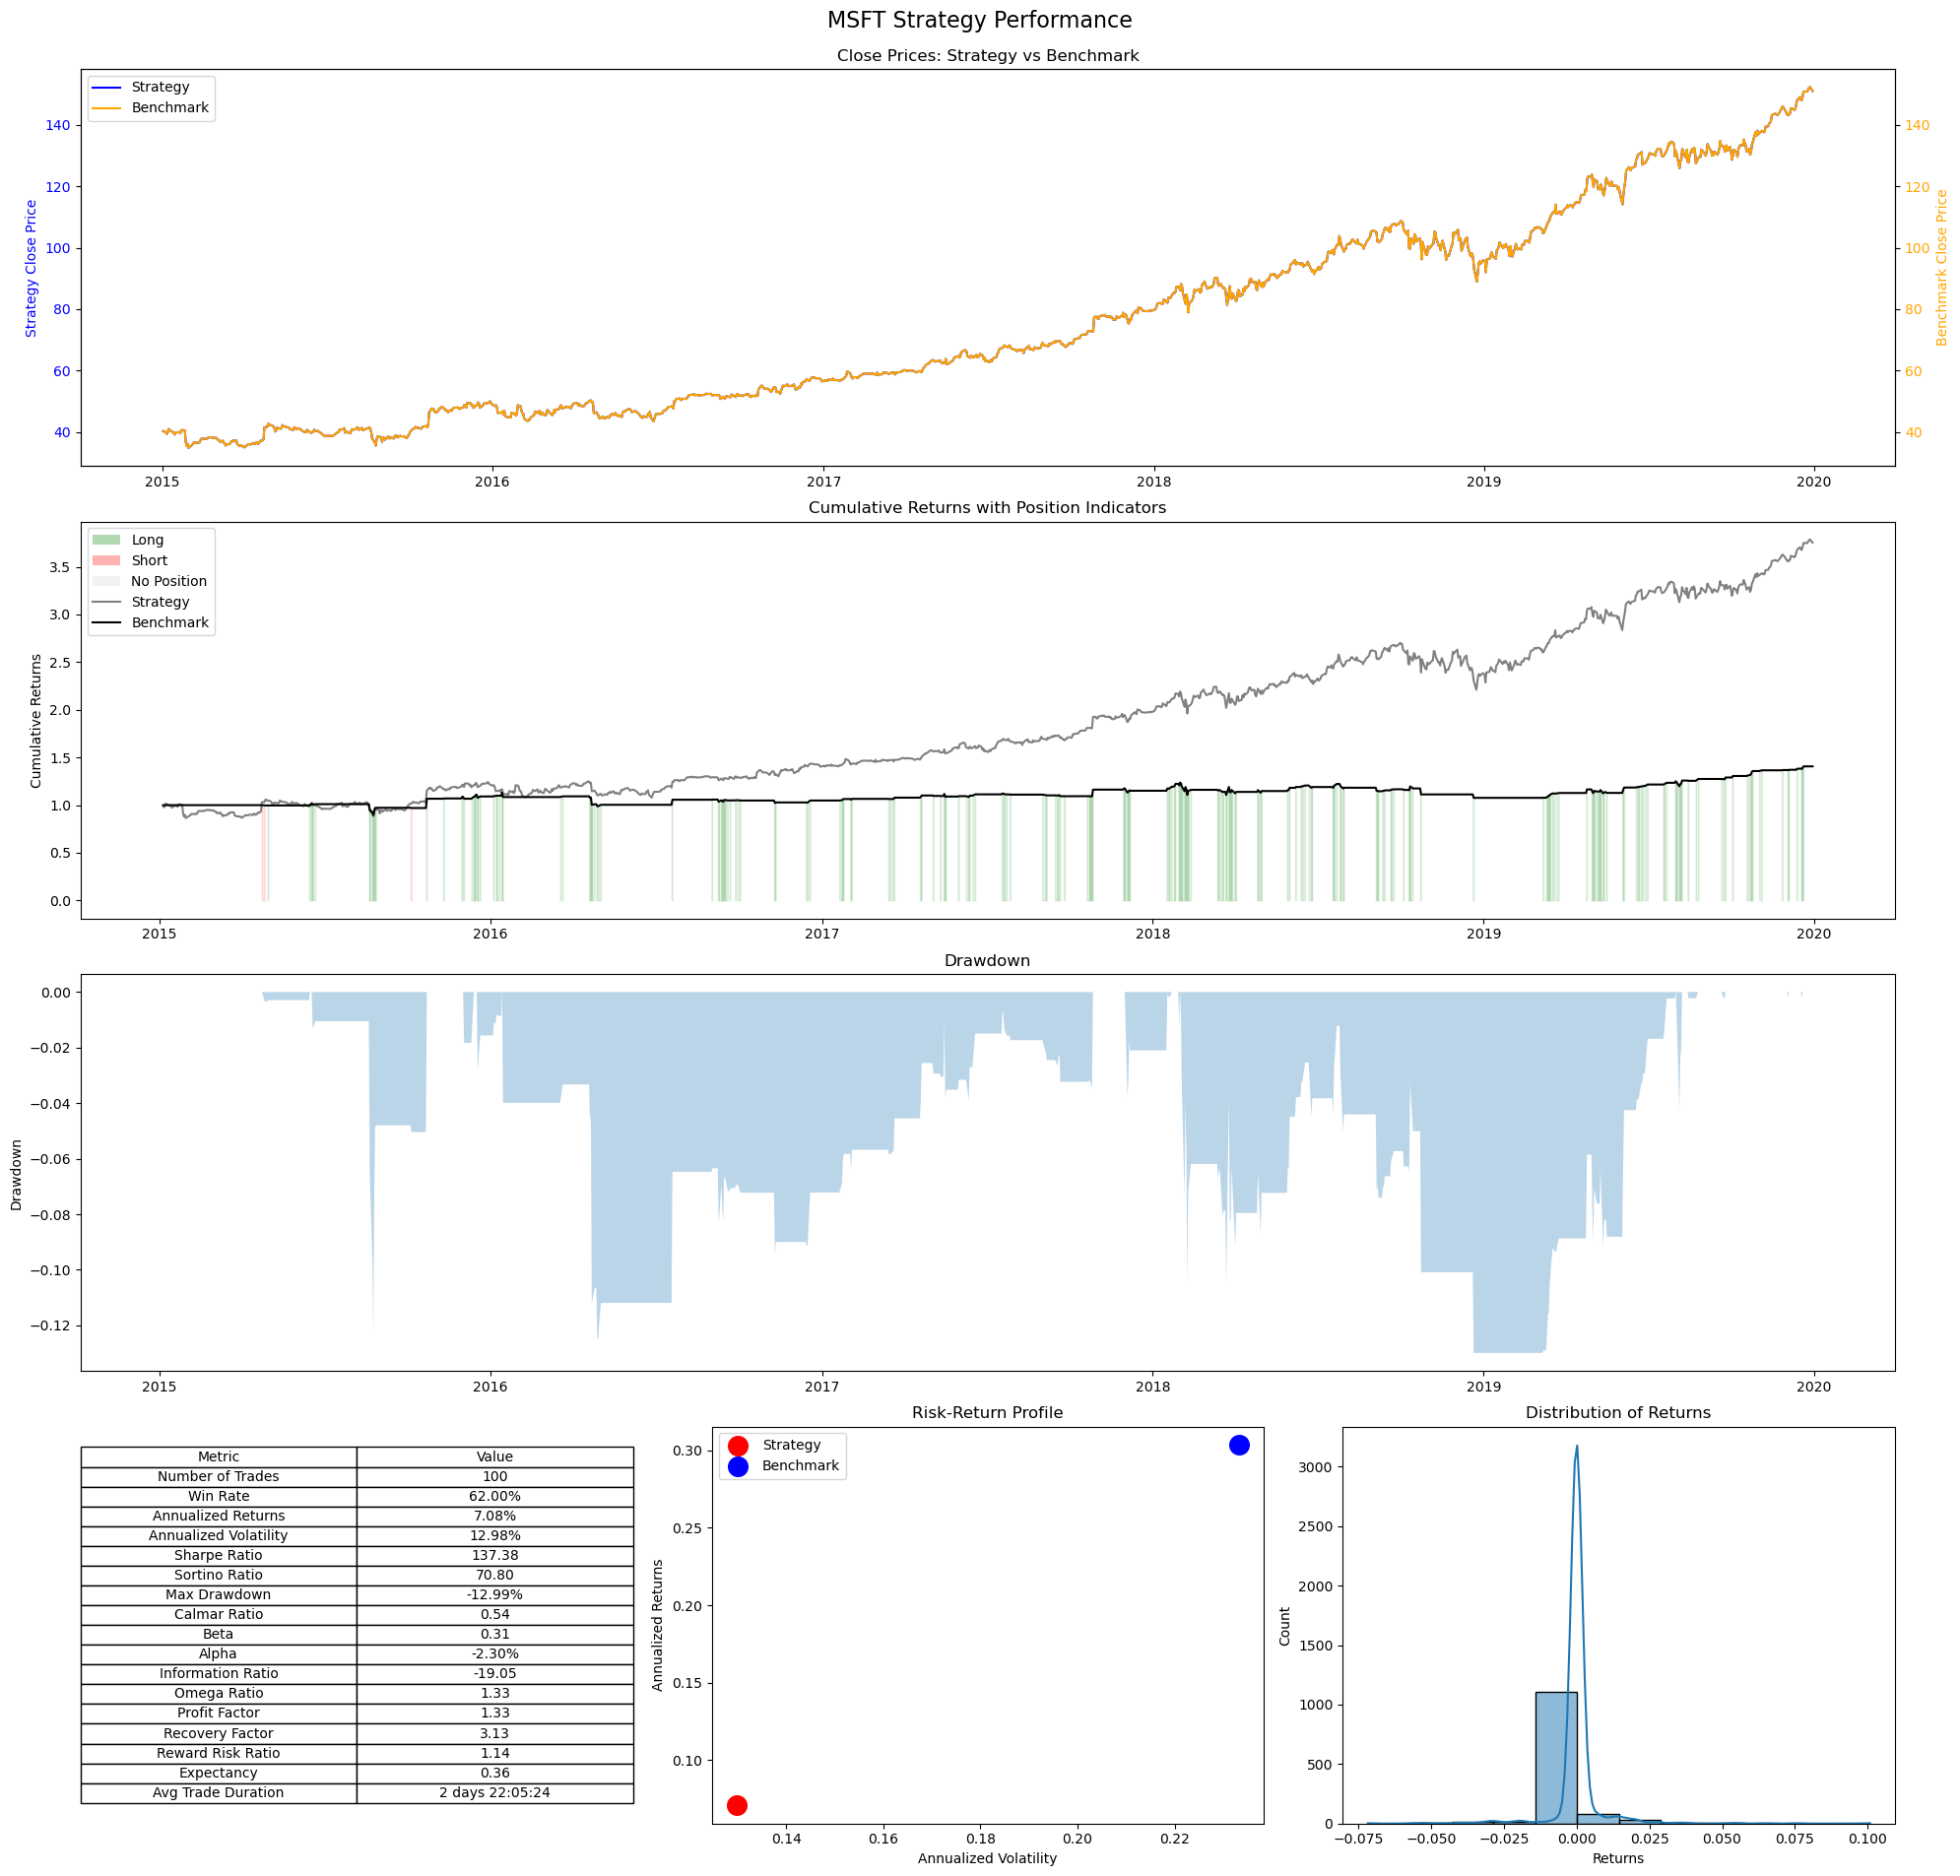

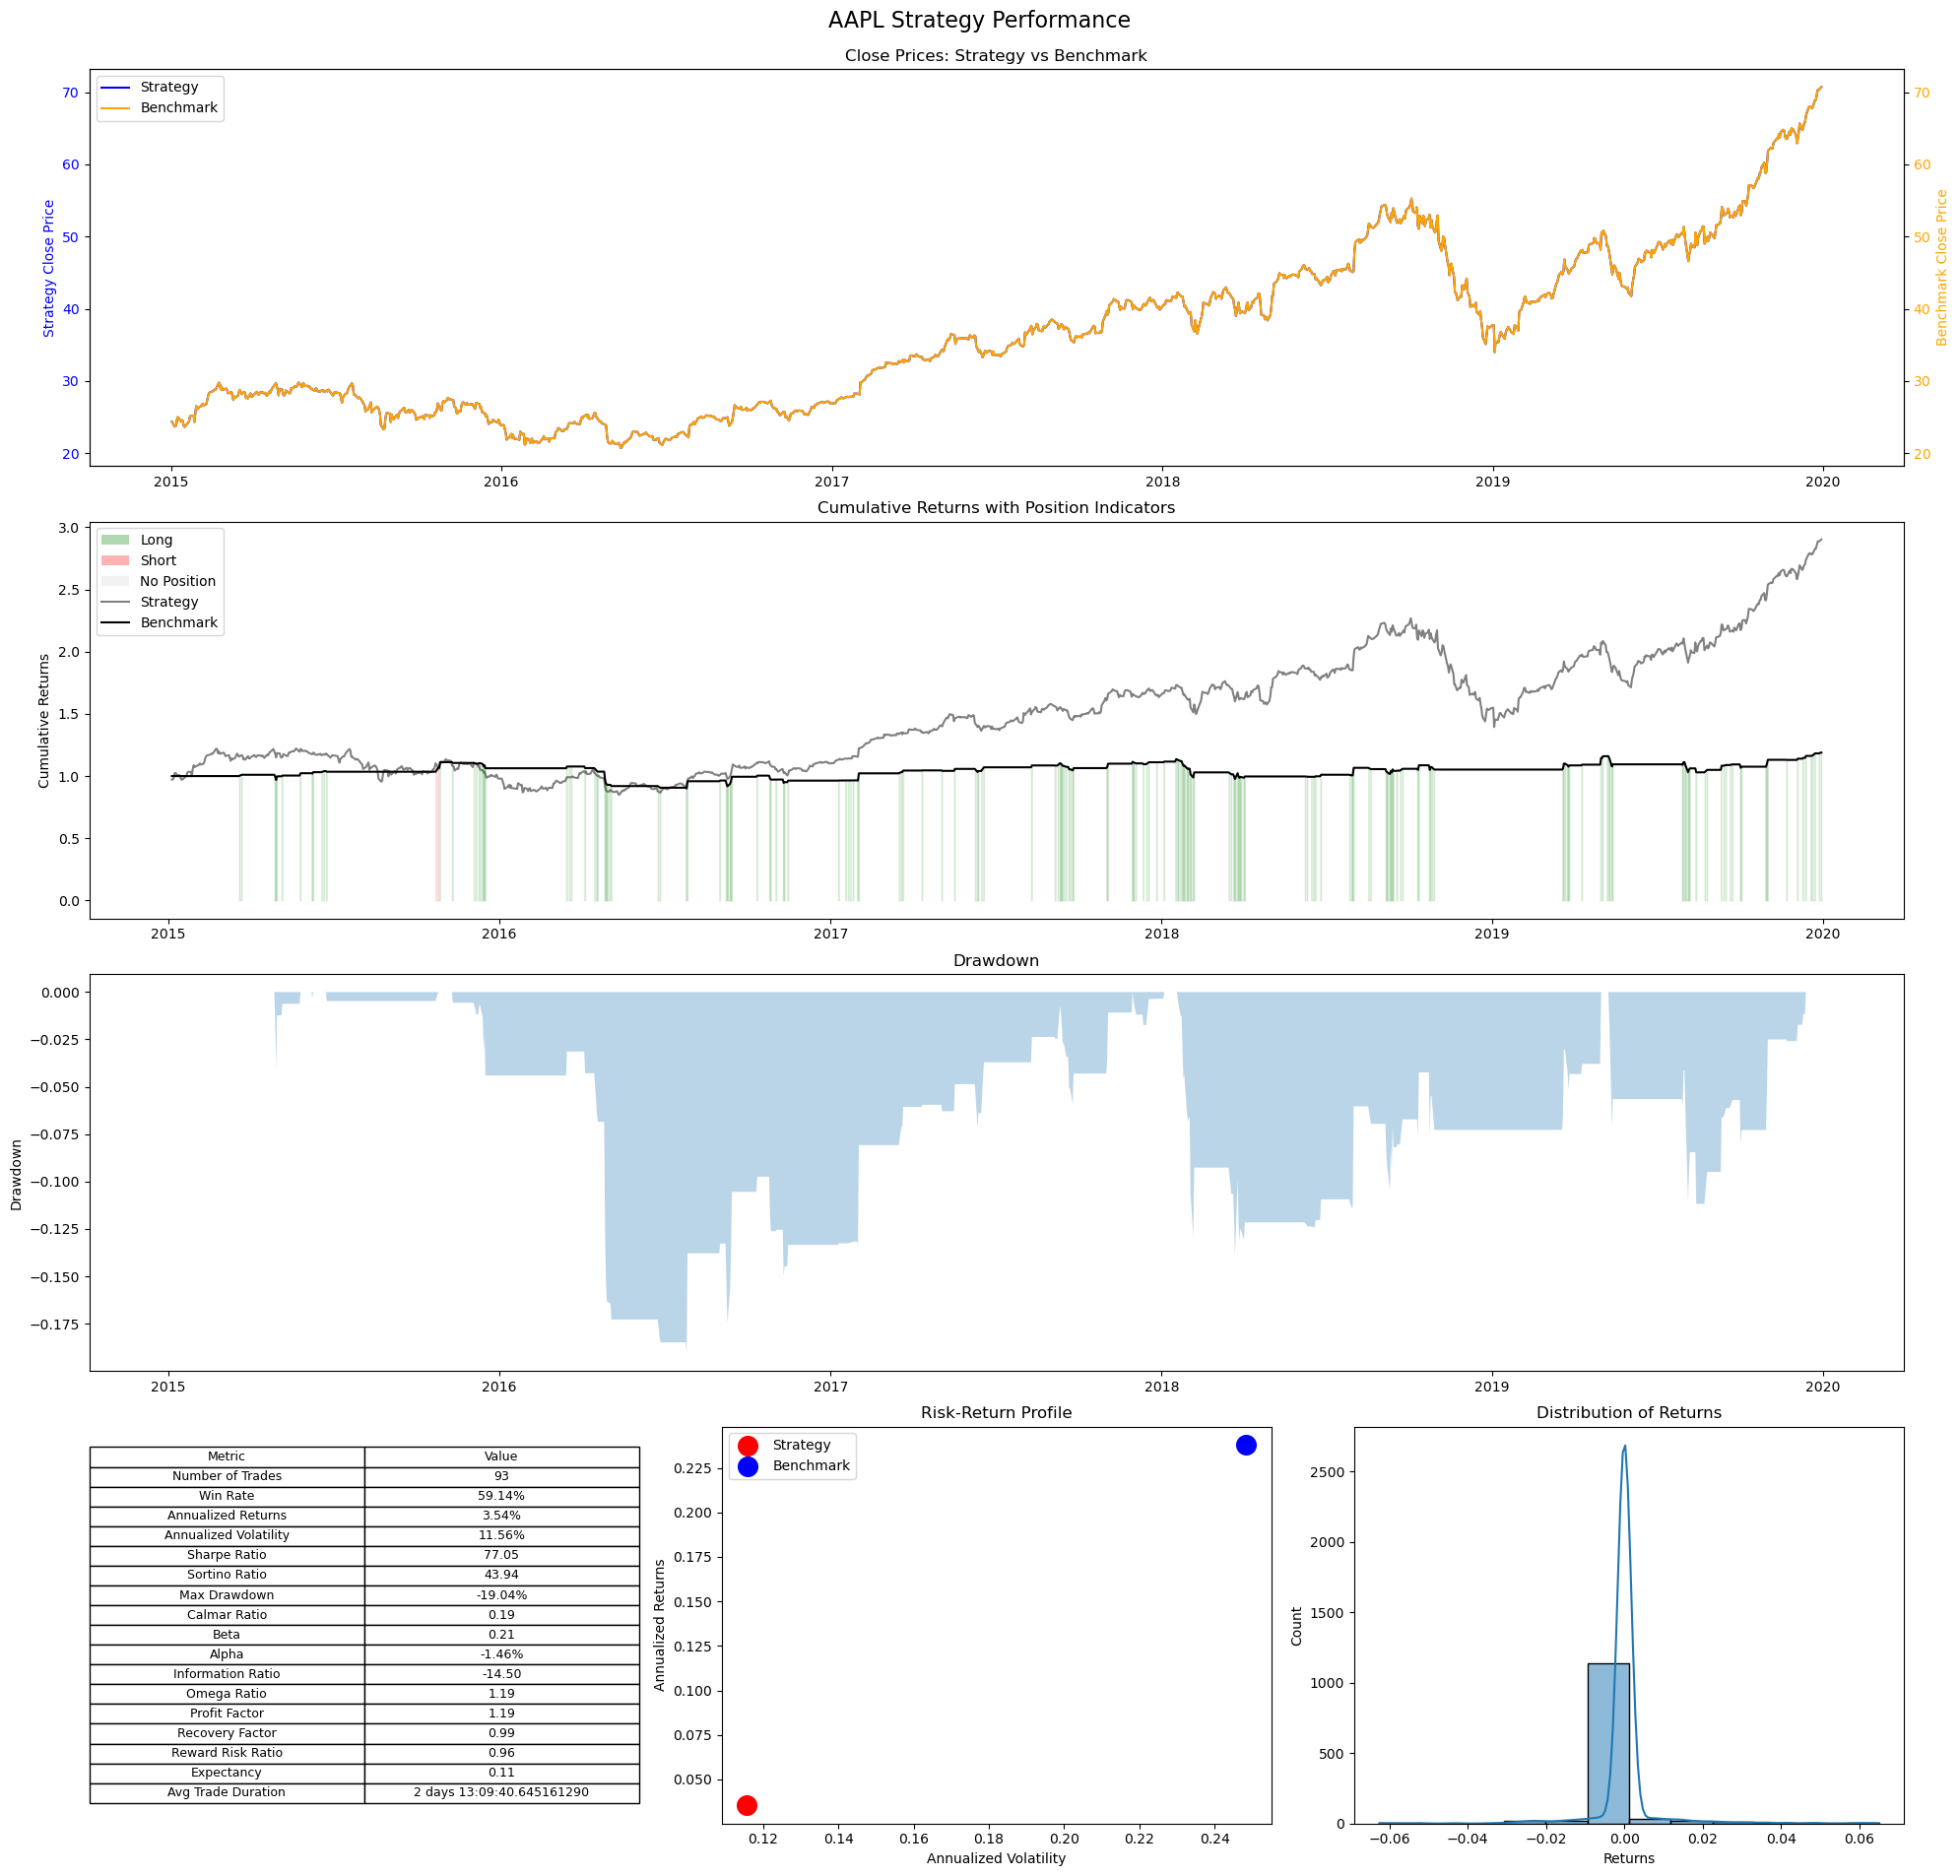

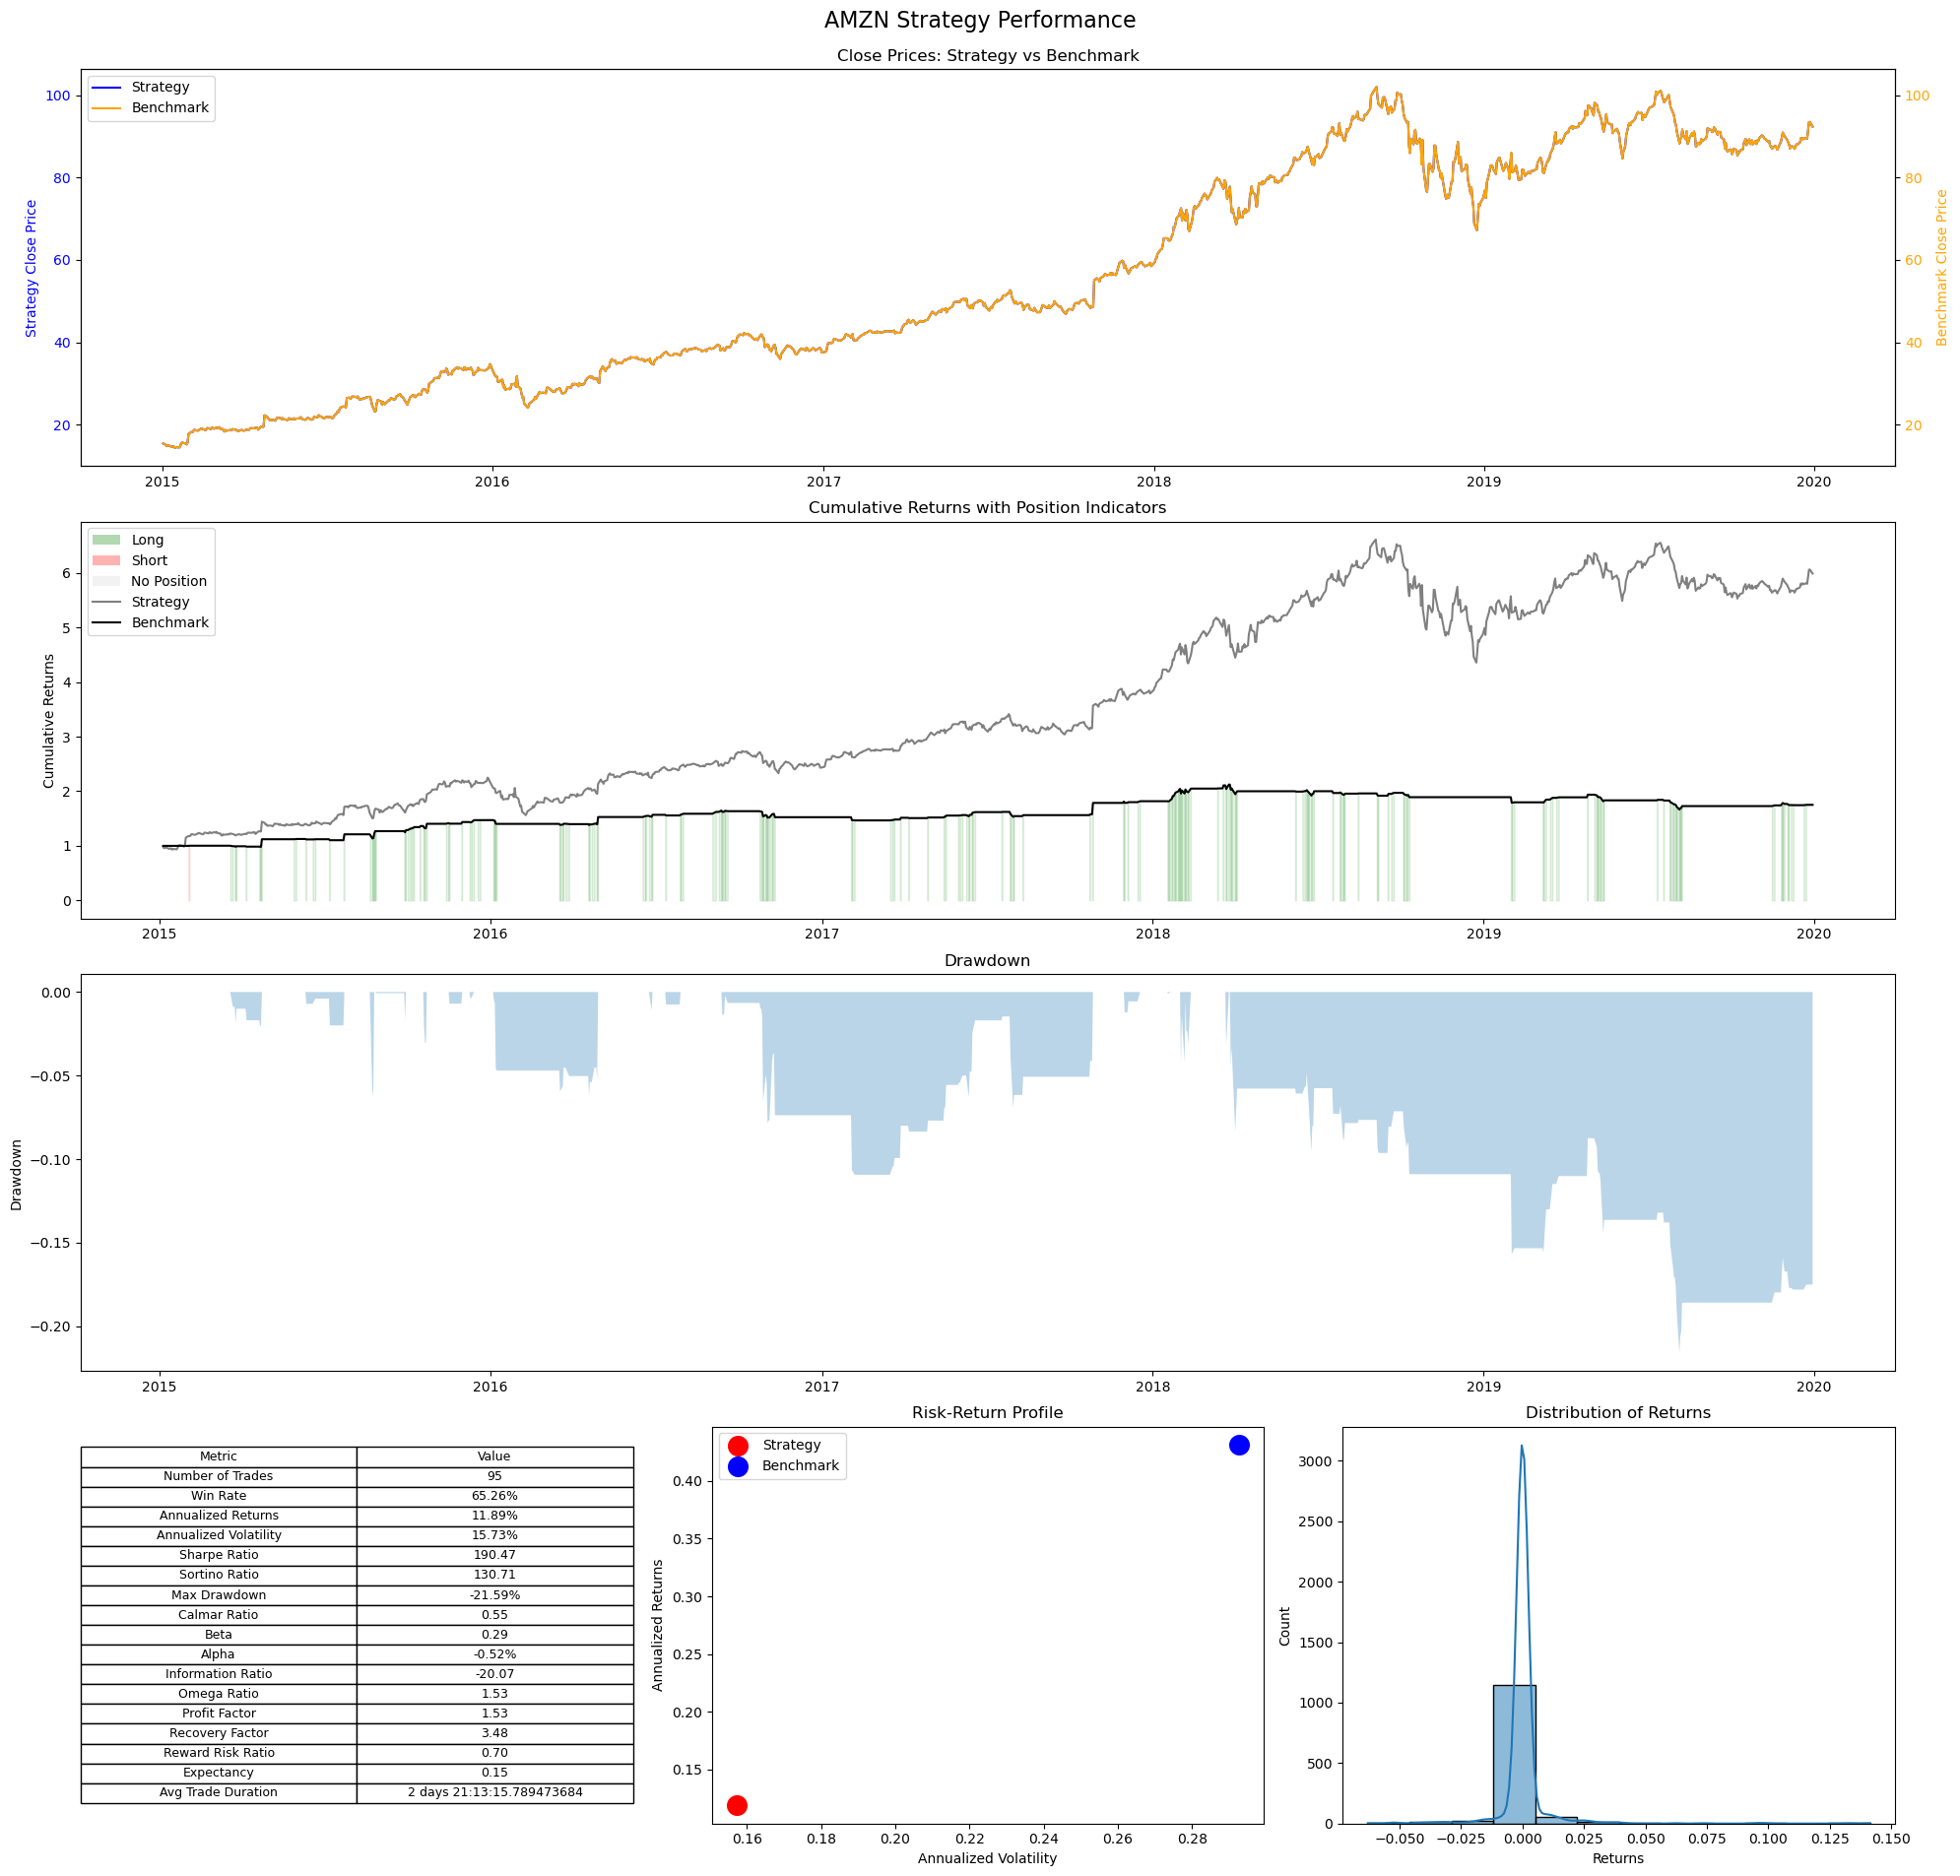

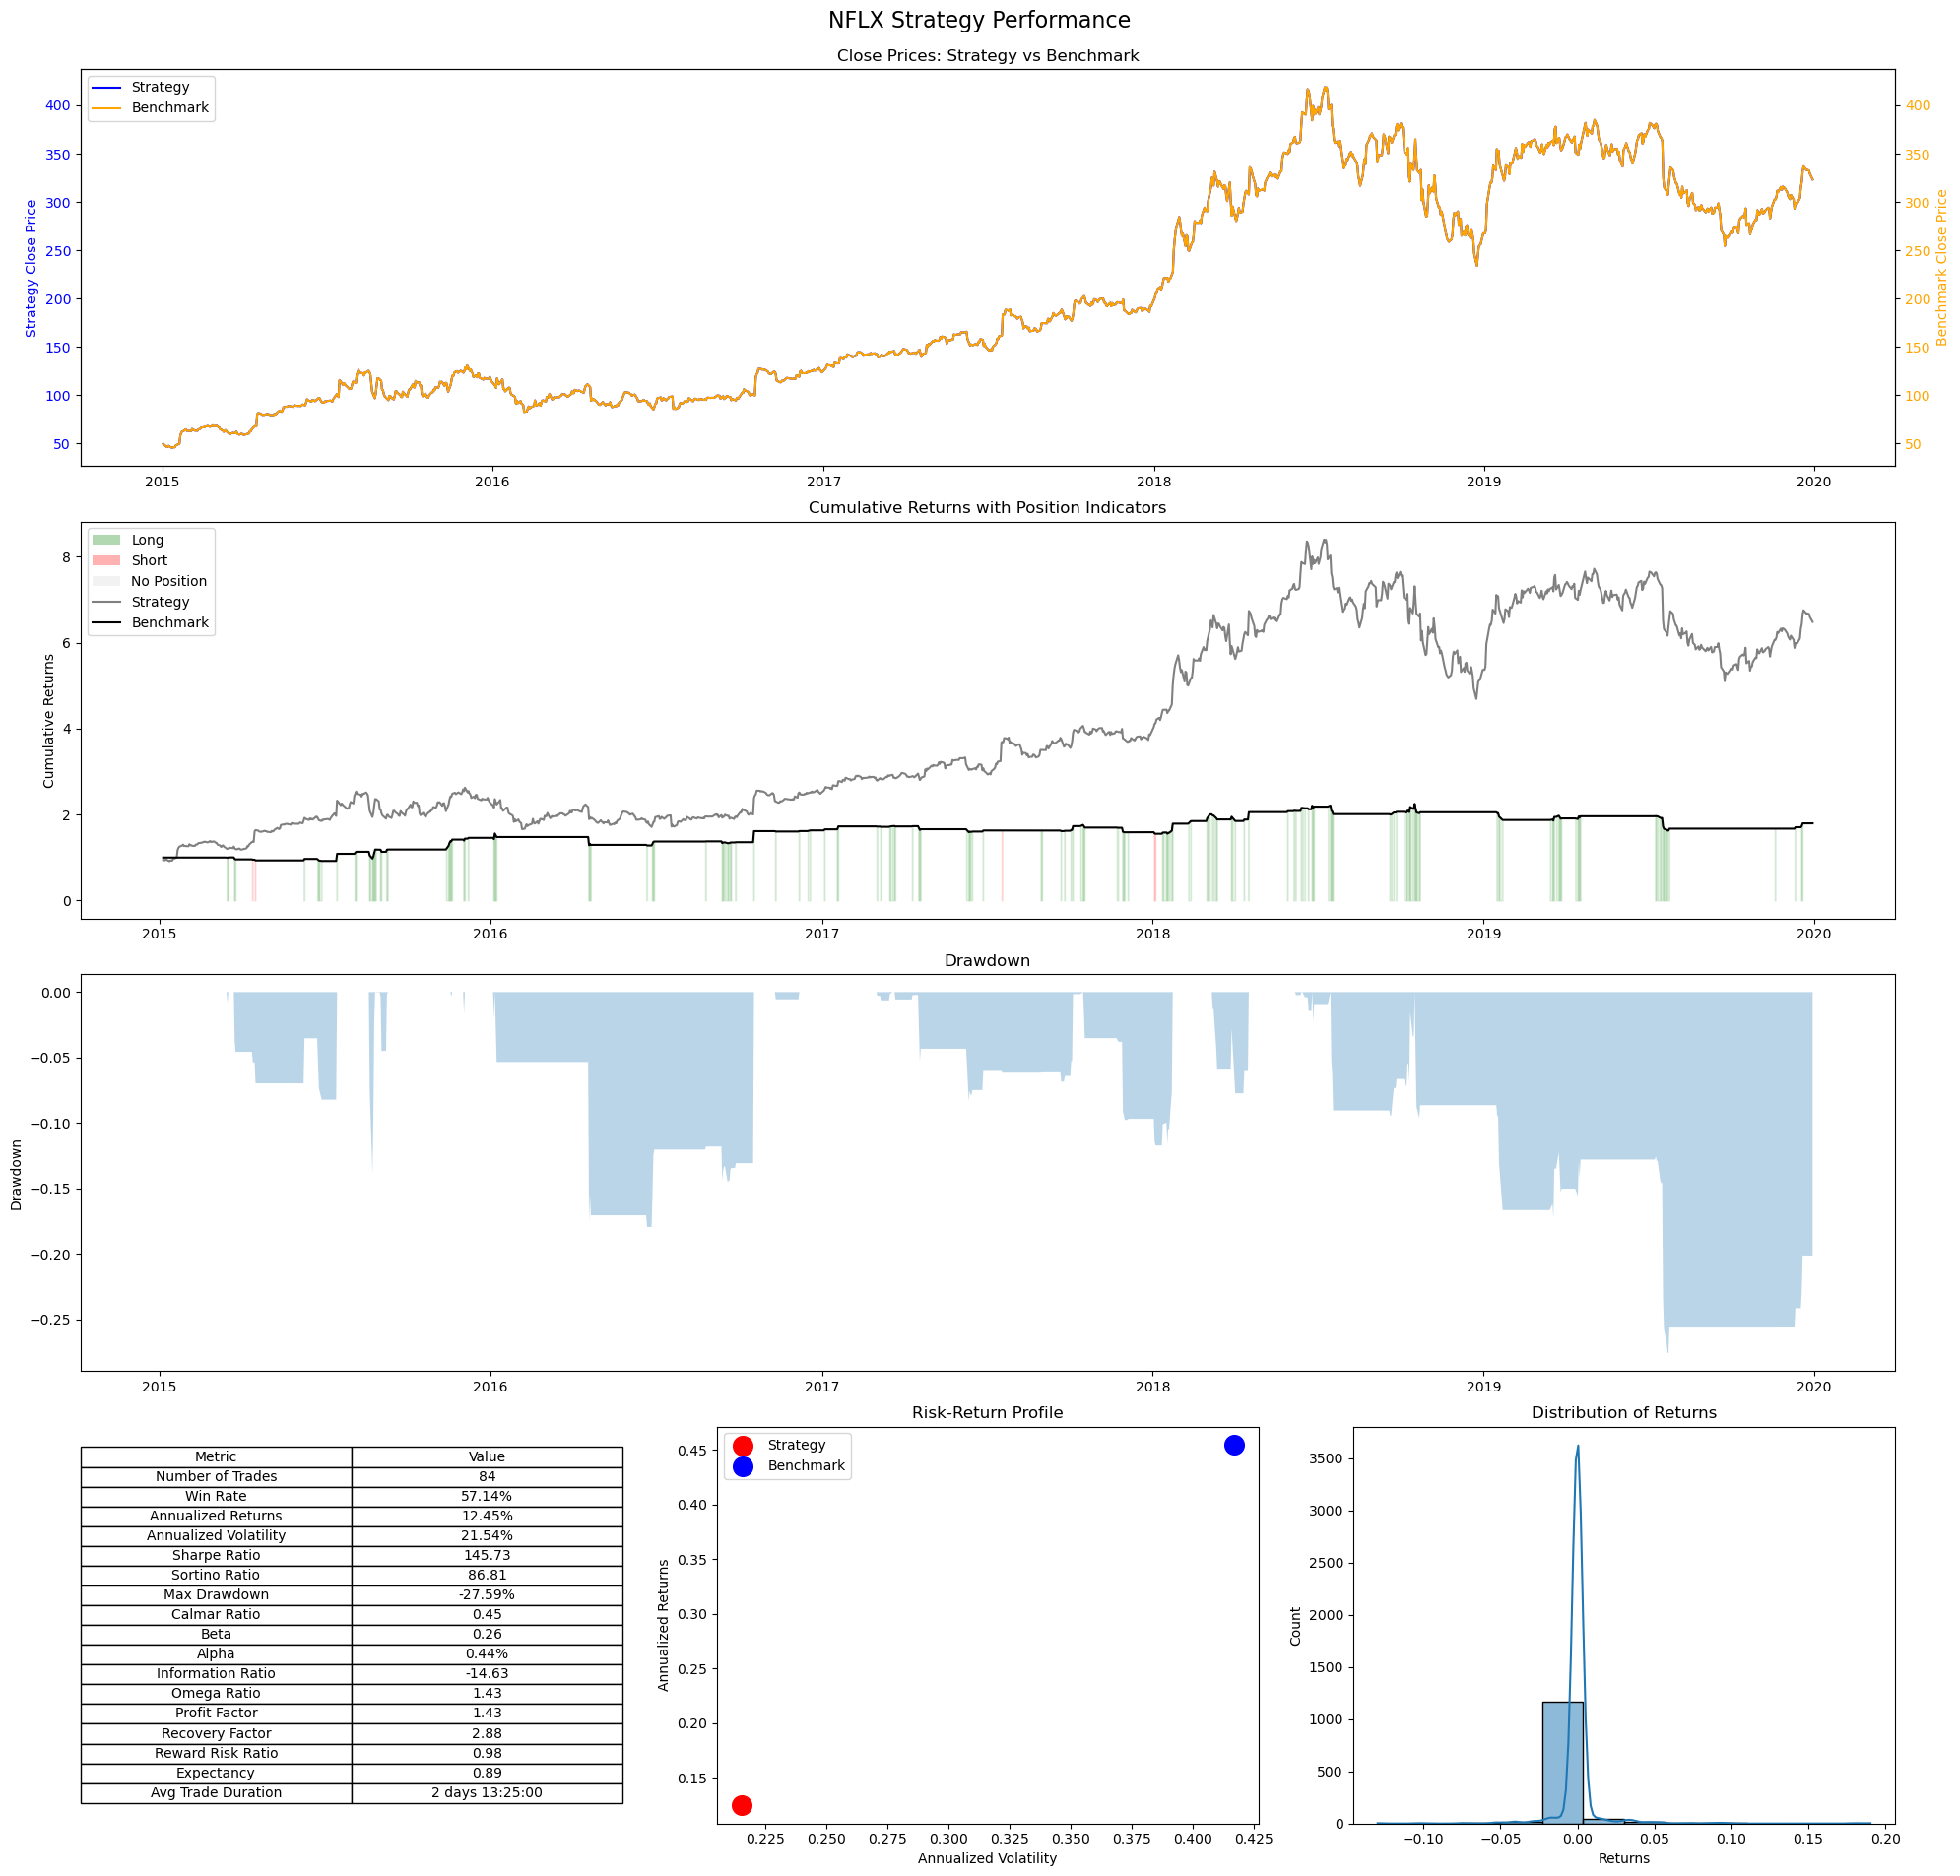

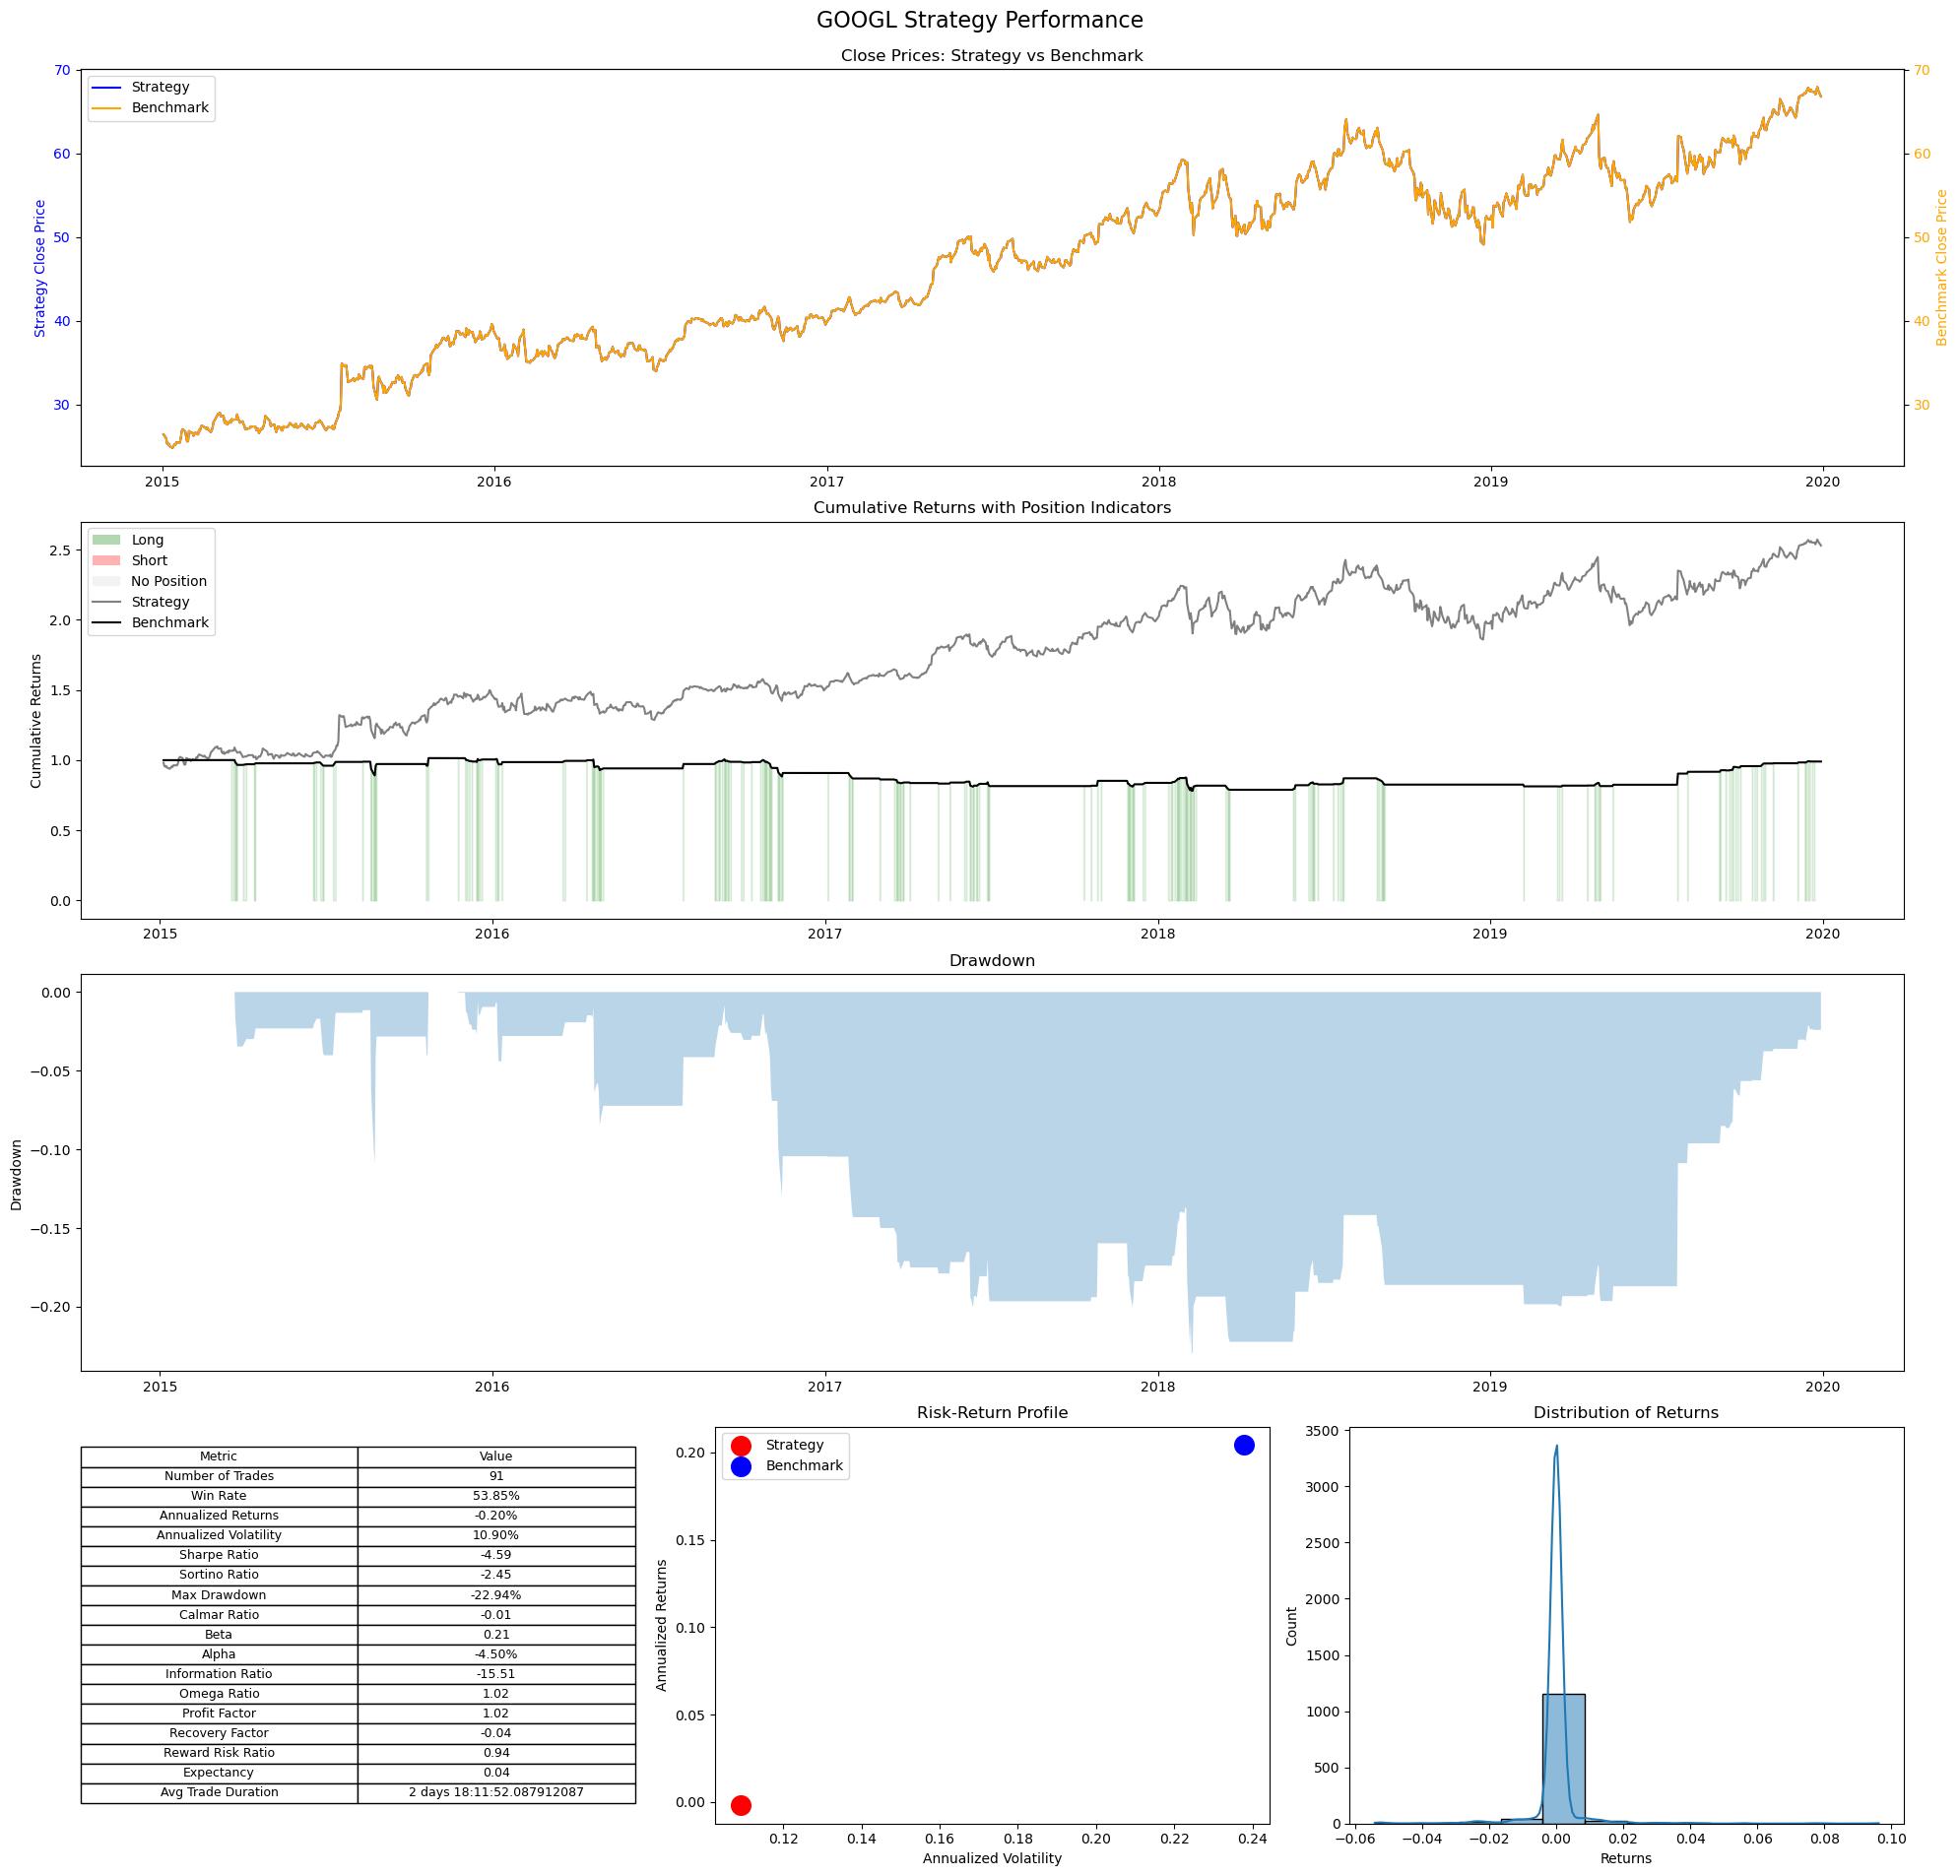

{'number_strategies': 5,
 'portfolio_annualized_return': 0.07612055092538261,
 'portfolio_annualized_volatility': 0.08892536387135441,
 'portfolio_sharpe_ratio': 0.8560049418015749,
 'portfolio_sortino_ratio': 0.5701195020111094,
 'portfolio_max_drawdown': 0.09966742330686737,
 'portfolio_calmar_ratio': 0.7637455489444532,
 'benchmark_annualized_return': 0.3467814527369819,
 'benchmark_annualized_volatility': 0.2236249226968016,
 'benchmark_sharpe_ratio': 1.550728105592954,
 'benchmark_sortino_ratio': 1.5035291647375006,
 'benchmark_max_drawdown': 0.28895656049113133,
 'benchmark_calmar_ratio': 1.2001162117501927,
 'beta': 0.23083767852358095,
 'alpha': -0.0039296745794571986,
 'annualized_treynor': 0.3297579121928598,
 'annualized_information': -1.3155029593584309,
 'omega_ratio': 1.3464065302758406,
 'profit_factor': 1.3464065302758401,
 'recovery_factor': 4.429207778257163}

In [148]:
# using the best performing parameters based on the highest sharpe ratio results
mf_reversion_list_strategies = []

for s in maang_stocks:
    strategy = YFinance_MF_Reversion_Strategy(
        symbol=s,
        start_date = '2015-01-01',
        end_date = '2019-12-31',
        interval = '1d',
        params = {'ma_window' : 21, 'z_threshold': 3, 'volume_threshold': 0.5, "ma_short": 20, "ma_long": 50}, 
        benchmark_symbol=s,
        risk_free_rate=0.0
    )
    strategy.strategy()
    strategy.calculate_strategy_performance()
    strategy.plot_performance()
    mf_reversion_list_strategies.append(strategy)

portfolio_mof_reversion = YFinancePortfolio(mf_reversion_list_strategies)
portfolio_mof_reversion.calculate_portfolio_performance()

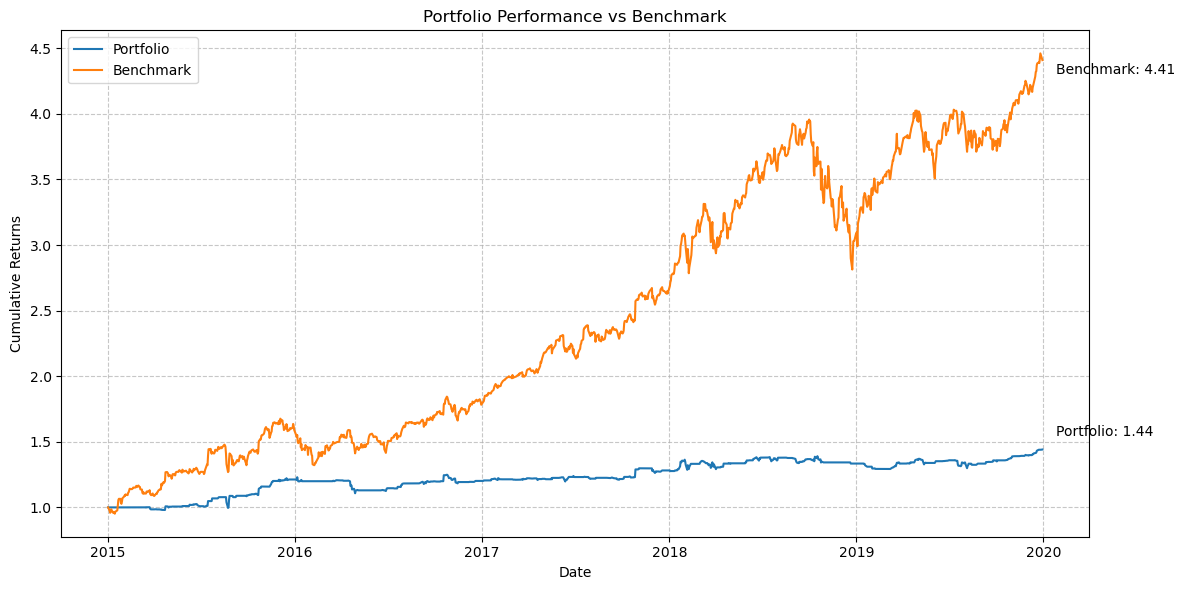

In [151]:
portfolio_mof_reversion.plot_overall_portfolio_performance()

In [152]:
portfolio_mof_reversion.portfolio_performance


{'number_strategies': 5,
 'portfolio_annualized_return': 0.07612055092538261,
 'portfolio_annualized_volatility': 0.08892536387135441,
 'portfolio_sharpe_ratio': 0.8560049418015749,
 'portfolio_sortino_ratio': 0.5701195020111094,
 'portfolio_max_drawdown': 0.09966742330686737,
 'portfolio_calmar_ratio': 0.7637455489444532,
 'benchmark_annualized_return': 0.3467814527369819,
 'benchmark_annualized_volatility': 0.2236249226968016,
 'benchmark_sharpe_ratio': 1.550728105592954,
 'benchmark_sortino_ratio': 1.5035291647375006,
 'benchmark_max_drawdown': 0.28895656049113133,
 'benchmark_calmar_ratio': 1.2001162117501927,
 'beta': 0.23083767852358095,
 'alpha': -0.0039296745794571986,
 'annualized_treynor': 0.3297579121928598,
 'annualized_information': -1.3155029593584309,
 'omega_ratio': 1.3464065302758406,
 'profit_factor': 1.3464065302758401,
 'recovery_factor': 4.429207778257163}

# Conclusion
In this notebook, we implement a Multi-Factor Mean Reversion Strategy on an equal-weighted portfolio of the MAANG (Meta, Apple, Amazon, Netflix, Google) stocks. The strategy leverages multiple indicators such as the Z-score, Bollinger Bands, and volume analysis, combined with trend-following components, to generate buy and sell signals. Additionally, we use these signals to construct a long-short portfolio and evaluate its performance against a Buy-and-Hold (BnH) benchmark for the same equal-weighted MAANG portfolio.

The results indicate that while the Multi-Factor Mean Reversion Strategy demonstrated lower risk and greater downside protection, it did not outperform the Buy-and-Hold strategy on a returns basis. However, the following key metrics provide insight into the strategy's strengths and weaknesses compared to the benchmark:

1. Risk
- The annualized volatility of the strategy is significantly lower at 8.89% compared to 22.36% for the BnH benchmark, indicating a much smoother return profile.
- The maximum drawdown is also considerably lower at 9.97% compared to 28.90% for the BnH strategy, highlighting better downside protection.
- The strategy exhibits a low beta of 0.23, suggesting that it is less sensitive to overall market movements, making it more suitable for environments with increased market uncertainty.

2. Returns
   - The strategy's annualized returns are 7.61%, which are significantly lower than the benchmark's 34.68%. This underperformance indicates that the strategy's mean-reversion focus might not fully capture the strong upward trends typically seen in a long-only portfolio like Buy-and-Hold.

3. Performance Metrics
   - The strategy's Sharpe ratio of 0.86 is notably lower than the benchmark's 1.55, indicating that, on a risk-adjusted basis, the strategy did not provide better compensation for the risk taken.
   - Similarly, the Sortino ratio (0.57) and the Calmar ratio (0.76) are both below the benchmark values (1.50 and 1.20, respectively), suggesting that the strategy could not outperform the BnH strategy in both upside performance and downside risk management.
   - A negative alpha of -0.39% reflects slight underperformance relative to the benchmark on a risk-adjusted basis.
   - The Information Ratio of -1.32 further confirms that the strategy underperformed the benchmark given the level of active risk taken.
   - However, the Omega Ratio (1.35) and Profit Factor (1.35) suggest that, relative to its own target return, the strategy still generated 34% more gains than losses.
   - The Recovery Factor of 4.43 is notably high, indicating the strategy’s ability to recover from drawdowns more effectively than the BnH strategy.


The portfolio demonstrates strong risk management with significantly lower volatility and drawdown compared to the benchmark, but at the cost of substantially lower returns. While risk-adjusted metrics are positive, they underperform the benchmark. 

Our team believes that the core foundation of the strategy works, however, we can improve on the limitations mentioned above.